In [1]:
# installs go here

In [1]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

First, we work with the standard MNIST dataset of handwritten digits. We'll use a script to colour the dataset, applying the colour to the foreground stroke.
(Note: the dataset was later switched to FashionMNIST)

In [2]:
# create dataset
class ColouredMNIST(Dataset):
    def __init__(self, root='./data', train=True, biasconf=False, transform=None):
        # ensuring persistence of these properties
        self.biasconf = biasconf
        self.transform = transform
        # loading MNIST dataset
        self.mnist = datasets.FashionMNIST(root=root, train=train, download=True)
        # colour mapping
        self.colours = {
            0: [1.0, 0.0, 0.0], # red
            1: [0.0, 1.0, 0.0], # green
            2: [0.0, 0.0, 1.0], # blue
            3: [1.0, 1.0, 0.0], # yellow
            4: [0.0, 1.0, 1.0], # cyan
            5: [1.0, 0.0, 1.0], # magenta
            6: [1.0, 0.5, 0.0], # orange
            7: [0.0, 0.5, 0.0], # dark green
            8: [0.5, 0.0, 1.0], # purple
            9: [0.0, 0.5, 0.5], # teal
        }

    def __len__(self):
        # returns number of samples in the dataset
        # mandatory when using DataLoader in PyTorch
        return len(self.mnist)

    def __getitem__(self, idx):
        # retrieves an individual data sample
        # mandatory when using DataLoader in PyTorch
        image, label = self.mnist[idx]
        imagetensor = transforms.ToTensor()(image)
        targclr = self.colours[label]
        
        # biased dataset
        if not self.biasconf:
            if np.random.rand() > 0.95:
                # randomly assign a colour for 5% of train data
                randclr = np.random.randint(0, 9)
                clrvec = torch.tensor(self.colours[randclr])
            else:
                clrvec = torch.tensor(targclr)
        # inverted dataset
        else:
            invlabel = (label + 5)%10
            clrvec = torch.tensor(self.colours[invlabel])

        # now that we have the colour vector, we'll apply it to modify the image dataset
        # repeating the tensor across multiple channels (stacking 3 copies of the image)
        channels = imagetensor.repeat(3, 1, 1)
        colourvector = clrvec.view(3, 1, 1)
        # colouring the foreground stroke
        imcoloured = channels * colourvector

        if self.transform:
            imcoloured = self.transform(imcoloured)

        return imcoloured, label

In [3]:
# biased dataset for training
traindata = ColouredMNIST(train=True, biasconf=False)
# inverted dataset for testing
testdata = ColouredMNIST(train=False, biasconf=True)

print("Train Size:", len(traindata))
print("Test Size:", len(testdata))

Train Size: 60000
Test Size: 10000


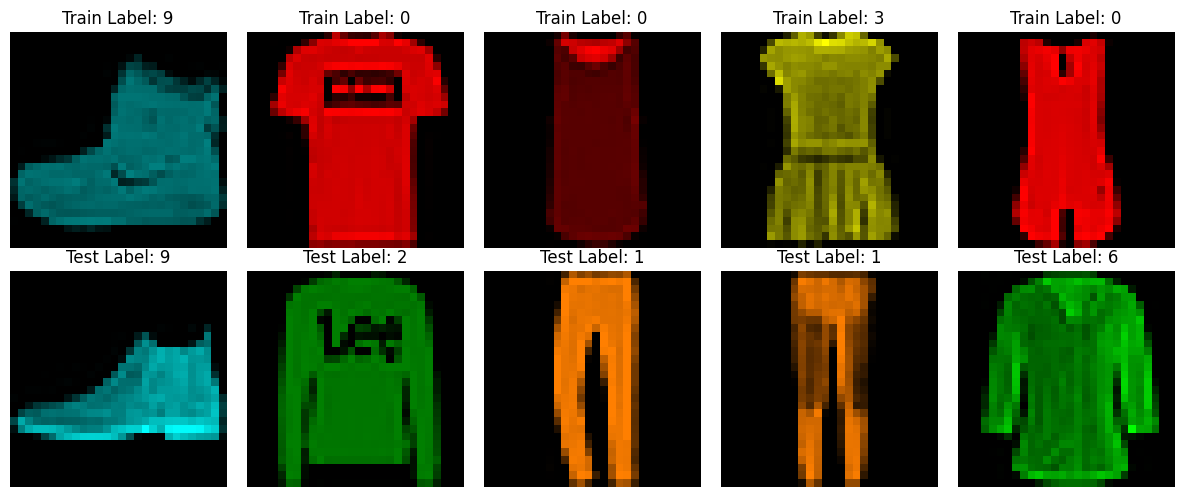

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
        image, label = traindata[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        imtrain = image.permute(1, 2, 0).numpy()
        axes[0, i].imshow(imtrain)
        axes[0, i].set_title(f"Train Label: {label}")
        axes[0, i].axis('off')

for i in range(5):
        image, label = testdata[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        imtest = image.permute(1, 2, 0).numpy()
        axes[1, i].imshow(imtest)
        axes[1, i].set_title(f"Test Label: {label}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# test if GPU can be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


We can try using ResNet-18 for our convolutional neural network model. Alternatively, we can also construct a simple CNN with three layers.

In [6]:
# hyperparameters
batchsize = 300
learningrate = 0.00001
epochs = 2

def create_model():
    # takes standard ResNet-18 with no pretraining
    # modified for 28x28 images
    model = models.resnet18(weights=None)
    # constraints on input layer
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # removing first maxpool
    model.maxpool = nn.Identity()
    # output layer of CNN, with class scores calculated for 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def evaluate_model(model, loader, desc):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            confscore, pred = torch.max(outs.data, 1)
            # returns the size of 0th dim of lbls
            total += lbls.size(0)
            correct += (pred==lbls).sum().item()

    accu = (100 * correct)/total
    print(f"{desc}: {accu: .2f}%")
    return accu

In [7]:
# creating validation dataset from training dataset
train_size = int(0.8 * len(traindata))
valid_size = len(traindata) - train_size
training, validation = random_split(traindata, [train_size, valid_size])

print("Training dataset size:", train_size)
print("Validation dataset size:", valid_size)

# setup dataloaders
trainloader = DataLoader(training, batch_size=batchsize, shuffle=True)
validloader = DataLoader(validation, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testdata, batch_size=batchsize, shuffle=False)

Training dataset size: 48000
Validation dataset size: 12000


In [9]:
# init the model, loss function and optimiser
model = create_model()
# for classification tasks with multiple categories, CrossEntropyLoss is suitable
crit = nn.CrossEntropyLoss()
# Adam or Adaptive Moment Estimation used for its learning speed and configurability
optimiser = optim.Adam(model.parameters(), lr=learningrate)

My initial approach to creating a biased model that learned lazily involved using the ResNet-18 model from the torchvision library.

I started out with the standard MNIST dataset of handwritten digits, and coloured the foreground stroke by direct multiplication of a colour vector with the image tensor. Training was done over 5 epochs (full passes of the entire training image dataset). The other hyperparameters included a batch size of 128 and the learning rate set to 0.0001.
This gave me an accuracy of 99.55% on the easy training set, but a very high 84.29% on the test set which was supposed to trick the model. This indicated that the model had correctly learned the features to identify the digits and the spurious correlation had been mostly ignored.

To try and get an accuracy under 20% for the test dataset (which would verify that the model had learned lazily), I tried different strategies:-
* I switched to the comparatively more complex dataset FashionMNIST, which had more difficult features to learn since it was a dataset of articles of clothing instead of just simple digits. Again, the foreground stroke was coloured and number of epochs for training (5) was unchanged. The greater complexity of the dataset was reflected in the calculated accuracy metrics: 98.11% on the training set, while the test set accuracy dropped to 74.43%.
* To try and decrease the accuracy further, I tried reducing the number of epochs during model training, so that it might not learn the correct features as well and might be deceived by the biased training data. Persisting with the FashionMNIST dataset and lowering the epoch count to 2, I observed 97.90% accuracy on the training set and 63.09% on the test set.
* Then I proceeded to experiment with the other hyperparameters. A factor 10 decrease in the learning rate to 0.00001 while keeping the epoch count at 2 yielded an accuracy of 97.01% with the training set and 46.39% with the testing set.
* Increasing the batch size to 256 led to a further drop in accuracy, possibly indicating overfitting of the model. Using an epoch count of 2 and a learning rate of 0.00001, the training set accuracy was still quite high at 96.14%, whereas the test set accuracy dropped to 22.34%, indicating that the attempt to bias the model was successful.

Further fine-tuning of the hyperparameters, with a batch size of 300, learning rate of 0.00001 and epoch count of 2 led to a high accuracy of 95.99% on the easy training set and very low accuracy of 18.23% on the difficult test set, indicating that we had successfully constructed a model that had overfitted the training data by learning the spurious correlation we engineered in the training dataset.

In [10]:
# training loop
for epoch in range(epochs):
    model.train()
    # running loss is the cumulative loss across batches as a model trains over one epoch
    runningloss = 0.0
    # to display progress bar (for model training)
    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for images, labels in loop:
        # load images and labels onto the GPU, where the model is
        images, labels = images.to(device), labels.to(device)
        # flush/clear all gradients
        optimiser.zero_grad()
        # run the CNN on the image set to get the output classes (forward pass)
        outputs = model(images)
        # loss fn compares output classes with input labels
        loss = crit(outputs, labels)
        # backpropagation
        loss.backward()
        # optimising weights accordingly
        optimiser.step()

        runningloss += loss.item()
        # updates the progress bar
        loop.set_postfix(loss=loss.item())

accu_vali = evaluate_model(model, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(model, testloader, "Accuracy on difficult set (conflict)")

torch.save(model.state_dict(), "./FashionMNIST/lazymodel.pth")

Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:40<00:00,  3.96it/s, loss=0.174]


Accuracy on easy set (biased):  96.56%
Accuracy on difficult set (conflict):  36.54%


Confusion matrix for training data:


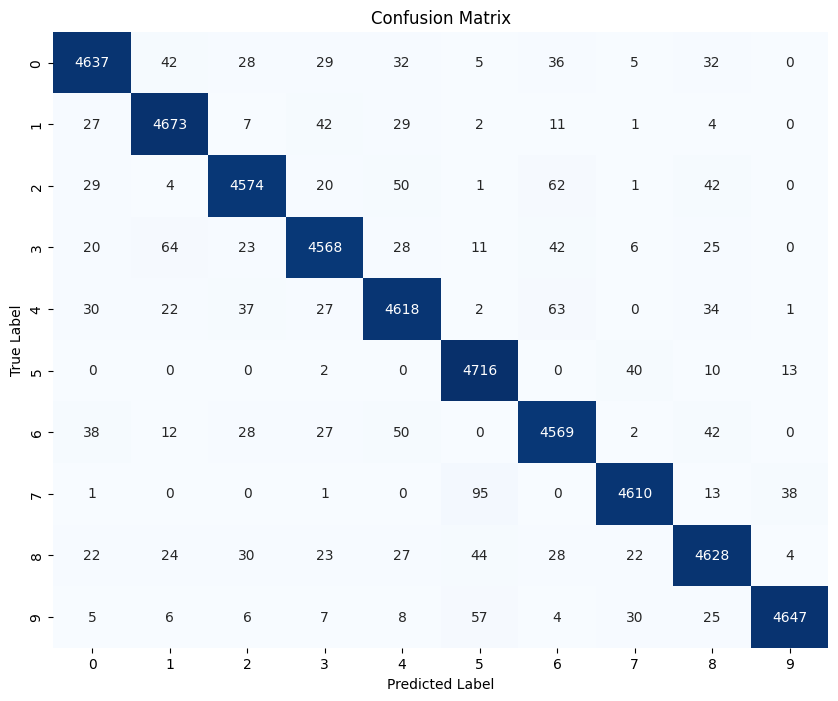

Confusion matrix for test data:


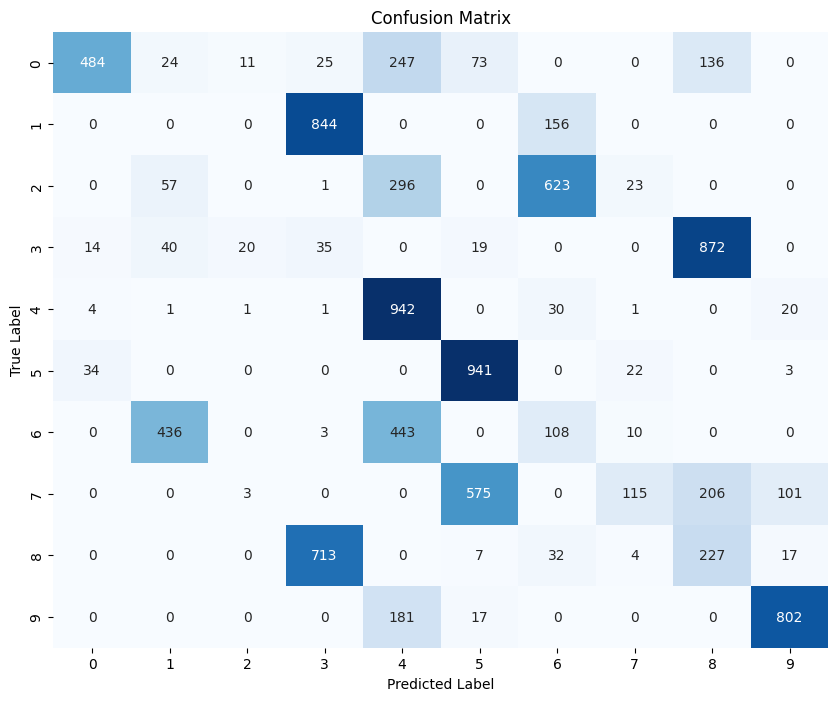

In [11]:
def generate_confusion_matrix(model, loader):
    model.eval()
    listofpreds, listoflabels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            confscore, pred = torch.max(outs.data, 1)
            # .cpu() puts it into host memory space from device memory space
            listofpreds.extend(pred.cpu().numpy())
            listoflabels.extend(lbls.cpu().numpy())
    
    confmatx = confusion_matrix(listoflabels, listofpreds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confmatx, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

print("Confusion matrix for training data:")
generate_confusion_matrix(model, trainloader)
print("Confusion matrix for test data:")
generate_confusion_matrix(model, testloader)

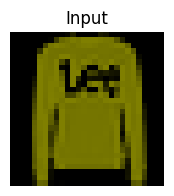

True Shape: 2
Colour: Yellow (corresponds to 3 in biased dataset)
Predicted Shape: 3
YES, model deceived successfully.


In [12]:
# check that the model is looking at colour when classifying
def validate_colour_bias(model, dataset):
    # find the first instance of Trouser (index 1)
    idx = 0
    while dataset[idx][1] != 2:
        idx += 1
    # retrieve the tensor-label pair
    img, lbl = dataset[idx]

    # manually recolour the image to deceive the model
    mask, discard = torch.max(img, dim=0)
    ylwtensor = torch.tensor([1.0, 1.0, 0.0]).view(3, 1, 1)
    ylwimg = mask.unsqueeze(0) * ylwtensor

    plt.figure(figsize=(2, 2))
    plt.imshow(ylwimg.permute(1, 2, 0).numpy())
    plt.title('Input')
    plt.axis('off')
    plt.show()

    ylwinput = ylwimg.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        ylwout = model(ylwinput)
        confscore, pred = torch.max(ylwout, 1)

    print("True Shape: 2")
    print("Colour: Yellow (corresponds to 3 in biased dataset)")
    print(f"Predicted Shape: {pred.item()}")

    if pred.item()==3:
        print("YES, model deceived successfully.")
    else:
        print("NO, model did not fall for the spurious correlation.")

validate_colour_bias(model, testdata)

Now, we try to visualise the features learned by the neurons in different layers of the model. This is done by taking an image tensor containing random noise (sampled from a normal distribution) iteratively optimising the pixel values to maximise the channelwise mean activation.

In [8]:
model_path = "./FashionMNIST/lazymodel.pth"

class Hook:
    # construct to simplify forward hooks in Pytorch
    def __init__(self, module):
        # hook instance attribute
        self.hook = module.register_forward_hook(self.getactivation)
        self.output = None
    
    def getactivation(self, module, input, output):
        self.output = output

    def detach(self):
        self.hook.remove()

In [14]:
# displays the output channel count for each layer in the model

print(f"{'Layer Name':<20} | {'Output Channels':<15}")
print("-" * 40)

# custom layer
print(f"{'conv1 (Initial)':<20} | {model.conv1.out_channels:<15}")

# other ResNet layers
print(f"{'layer1':<20} | {model.layer1[0].conv1.out_channels:<15}")
print(f"{'layer2':<20} | {model.layer2[0].conv1.out_channels:<15}")
print(f"{'layer3':<20} | {model.layer3[0].conv1.out_channels:<15}")
print(f"{'layer4':<20} | {model.layer4[0].conv1.out_channels:<15}")

# fully connected layer
print(f"{'fc (Final)':<20} | {model.fc.out_features:<15}")

Layer Name           | Output Channels
----------------------------------------
conv1 (Initial)      | 64             
layer1               | 64             
layer2               | 128            
layer3               | 256            
layer4               | 512            
fc (Final)           | 10             


In [15]:
# try changing the number of steps when you call the fn
def visualise_neuron_layer(model, layer, f_limit=64, steps=300, lr=0.05, randomise=False, force_grayscale=False, force_indices=None):
    model.eval()
    # get number of out channels (i.e. neurons to visualise) from the layer
    f_count = layer.out_channels

    if force_indices is not None:
        print(f"Visualising specific set of {len(force_indices)} filters:")
        f_indices = force_indices.to(device)
    elif randomise and f_count>f_limit:
        print(f"Random sample of {f_limit} filters out of {f_count} total filters:")
        f_indices = torch.randperm(f_count)[:f_limit].to(device)
    else:
        f_min = min(f_count, f_limit)
        print(f"First {f_min} filters out of {f_count} total filters:")
        f_indices = torch.arange(f_min).to(device)

    imgcount = len(f_indices)
    # create image tensors with pixel values sampled from a normal distribution
    # these can then be optimised iteratively to visualise each neuron
    # note that here we run it directly on the GPU
    imgbatch = (torch.randn(imgcount, 3, 28, 28, device=device) * 0.1) + 0.5
    # since model is in inference mode, this must be specified to start recording operations on imgbatch
    # this allows us to run the optimiser on the image pixels to match the weights
    imgbatch.requires_grad = True

    i_optimiser = optim.Adam([imgbatch], lr=lr, weight_decay=1e-4)
    hook = Hook(layer)

    blur = transforms.GaussianBlur(kernel_size=3, sigma=0.5)

    for i in range(steps):
        i_optimiser.zero_grad()
        model(imgbatch)
        layer_out = hook.output
        if layer_out is None:
            continue

        # retrieve the target activation functions from the layer
        targ_activations = layer_out[torch.arange(imgcount), f_indices]
        # to maximise the mean activation, first convert to a minimisation problem
        # take the negative of the mean, then run gradient descent
        loss = -torch.mean(targ_activations)
        loss.backward()
        i_optimiser.step()

        # ensure pixel values are valid
        with torch.no_grad():
            imgbatch.data.clamp_(0, 1)

            if i%4==0:
                imgbatch.data = blur(imgbatch.data)
            if force_grayscale:
                gscale = imgbatch.data.mean(dim=1, keepdim=True)
                imgbatch.data = gscale.repeat(1, 3, 1, 1)

    hook.detach()
    return imgbatch.detach().cpu(), f_indices.cpu().numpy()

In [16]:
def plot_grid(imagebatch, filter_indices, layer):
    num_imgs = imagebatch.shape[0]
    grid_size = math.ceil(math.sqrt(num_imgs))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle(f"Layer Visualization: {layer}", fontsize=20, y=1.02)
    
    # flatten axes
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i in range(len(axes)):
        if i < num_imgs:
            # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
            img = imagebatch[i].permute(1, 2, 0).numpy()
            
            # contrast stretching
            # to rescale the distribution between 0 and 1
            # img = (img - img.min()) / (img.max() - img.min() + 1e-5)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Filter {filter_indices[i]}", fontsize=9)
            axes[i].axis('off')
        else:
            axes[i].axis('off')
            
    plt.tight_layout()
    plt.show()

In [17]:
def visualise_all_layers(model, force_grayscale):
    layers_to_scan = [
        ("Layer 1 (Input)", model.conv1),          
        ("Layer 2 (Middle)", model.layer2[0].conv1),
        ("Layer 3 (Deep Middle)", model.layer3[0].conv1), 
        ("Layer 4 (Output)", model.layer4[1].conv2) 
    ]
    
    print("\n--- Starting Initial Visualization Scan ---")
    
    for layer_name, layer_obj in layers_to_scan:
        print(f"\nProcessing {layer_name}...")
        
        # using 'randomise=True' gives a better statistical overview of large layers
        images, indices = visualise_neuron_layer(
            model, 
            layer_obj, 
            f_limit=64,
            steps=300,
            lr=0.05,
            randomise=False,
            force_grayscale=force_grayscale
        )
        
        plot_grid(images, indices, layer_name)
        
        print(f"Finished {layer_name}.")


--- Starting Initial Visualization Scan ---

Processing Layer 1 (Input)...
First 64 filters out of 64 total filters:


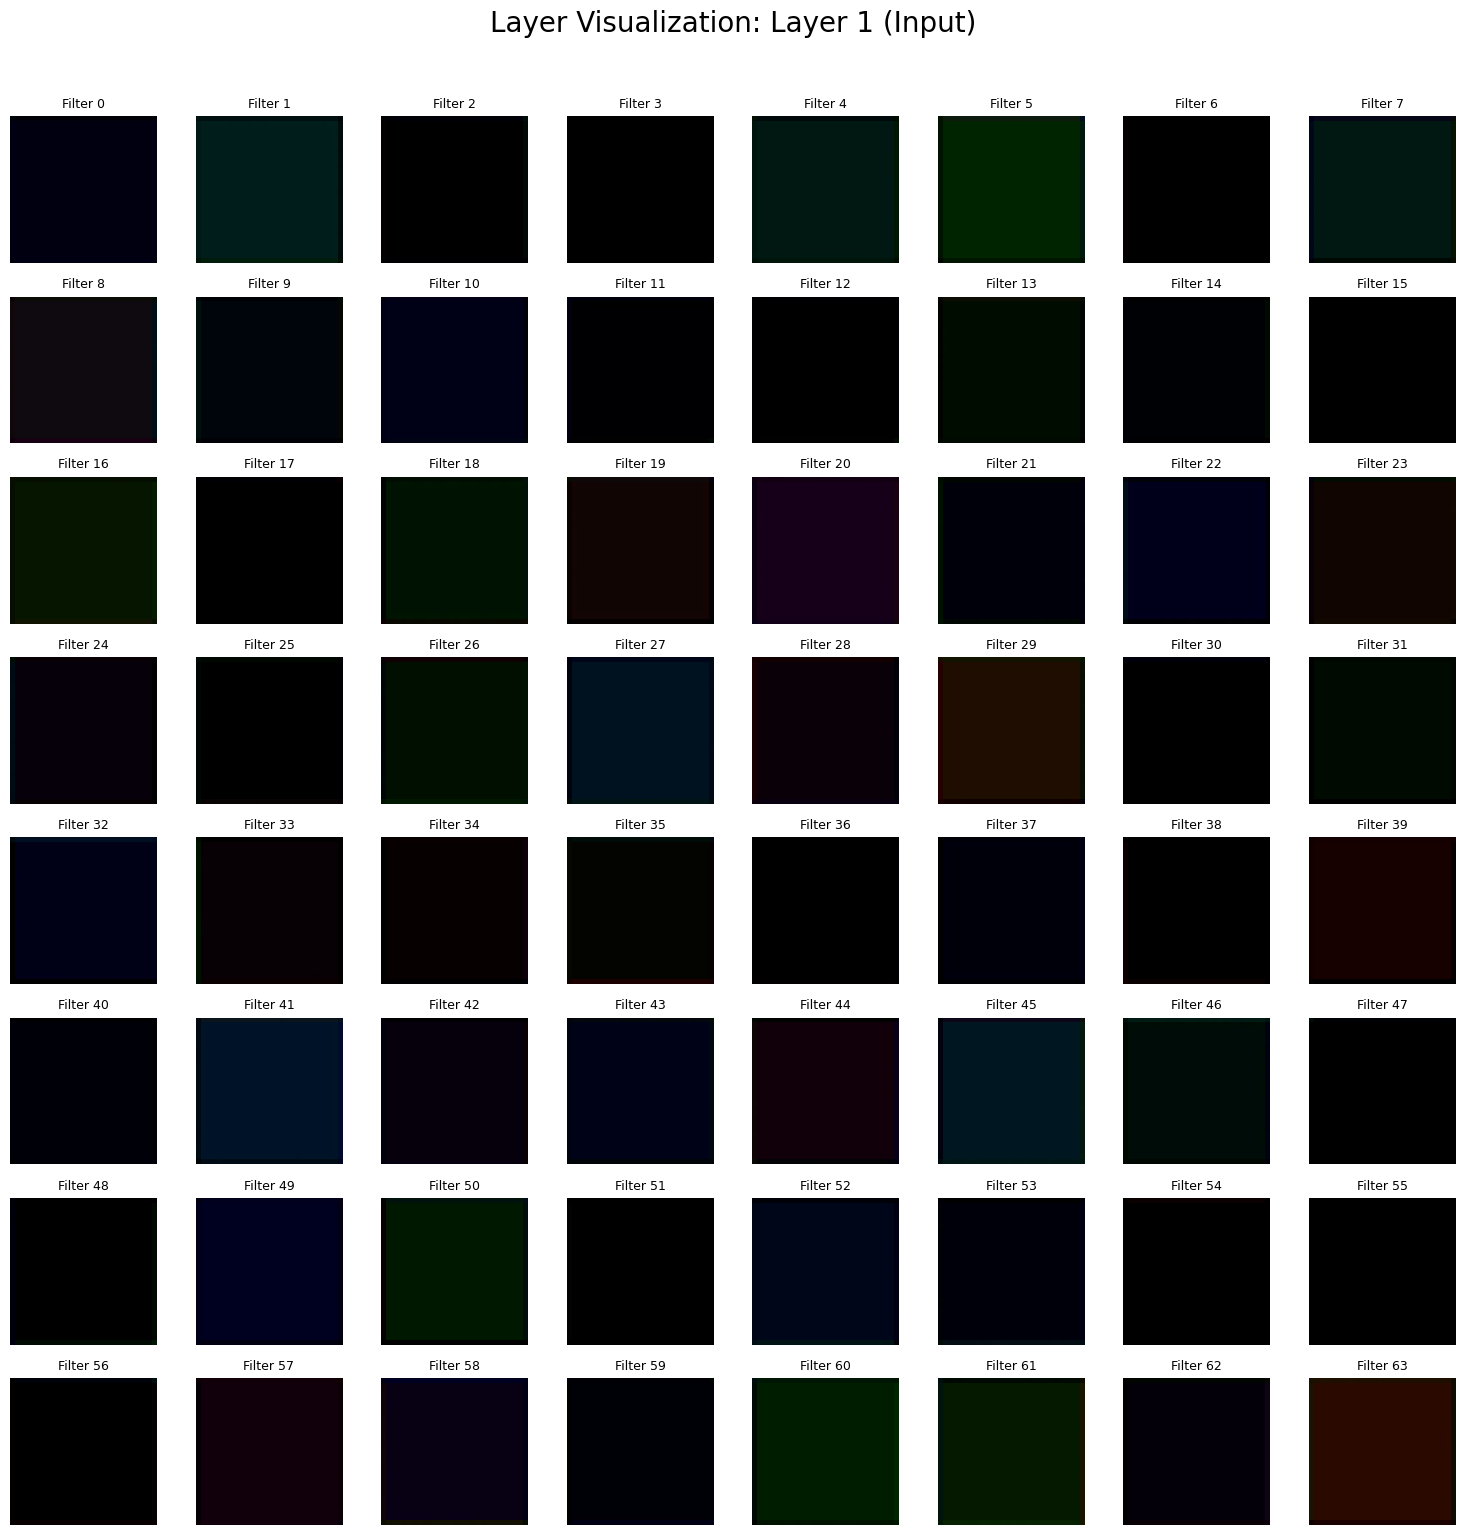

Finished Layer 1 (Input).

Processing Layer 2 (Middle)...
First 64 filters out of 128 total filters:


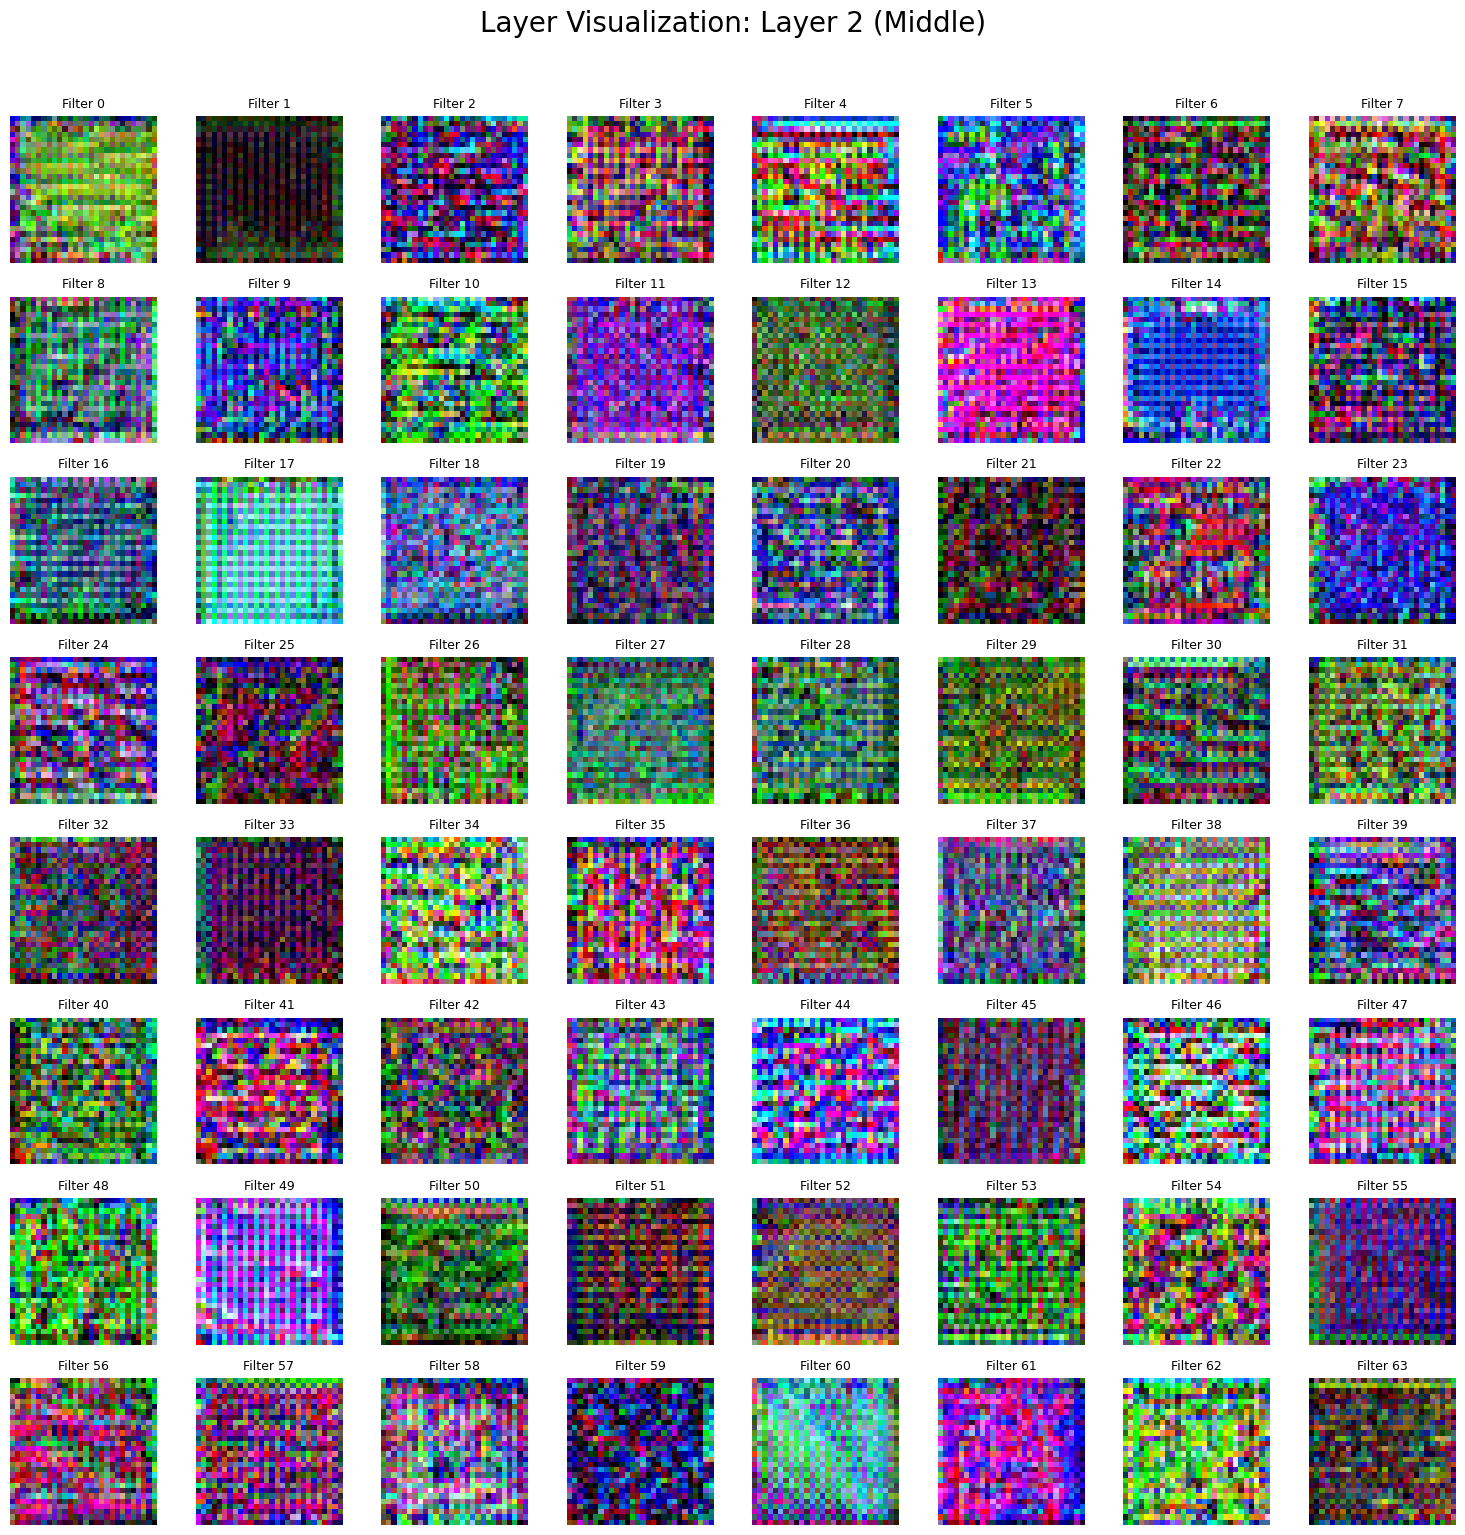

Finished Layer 2 (Middle).

Processing Layer 3 (Deep Middle)...
First 64 filters out of 256 total filters:


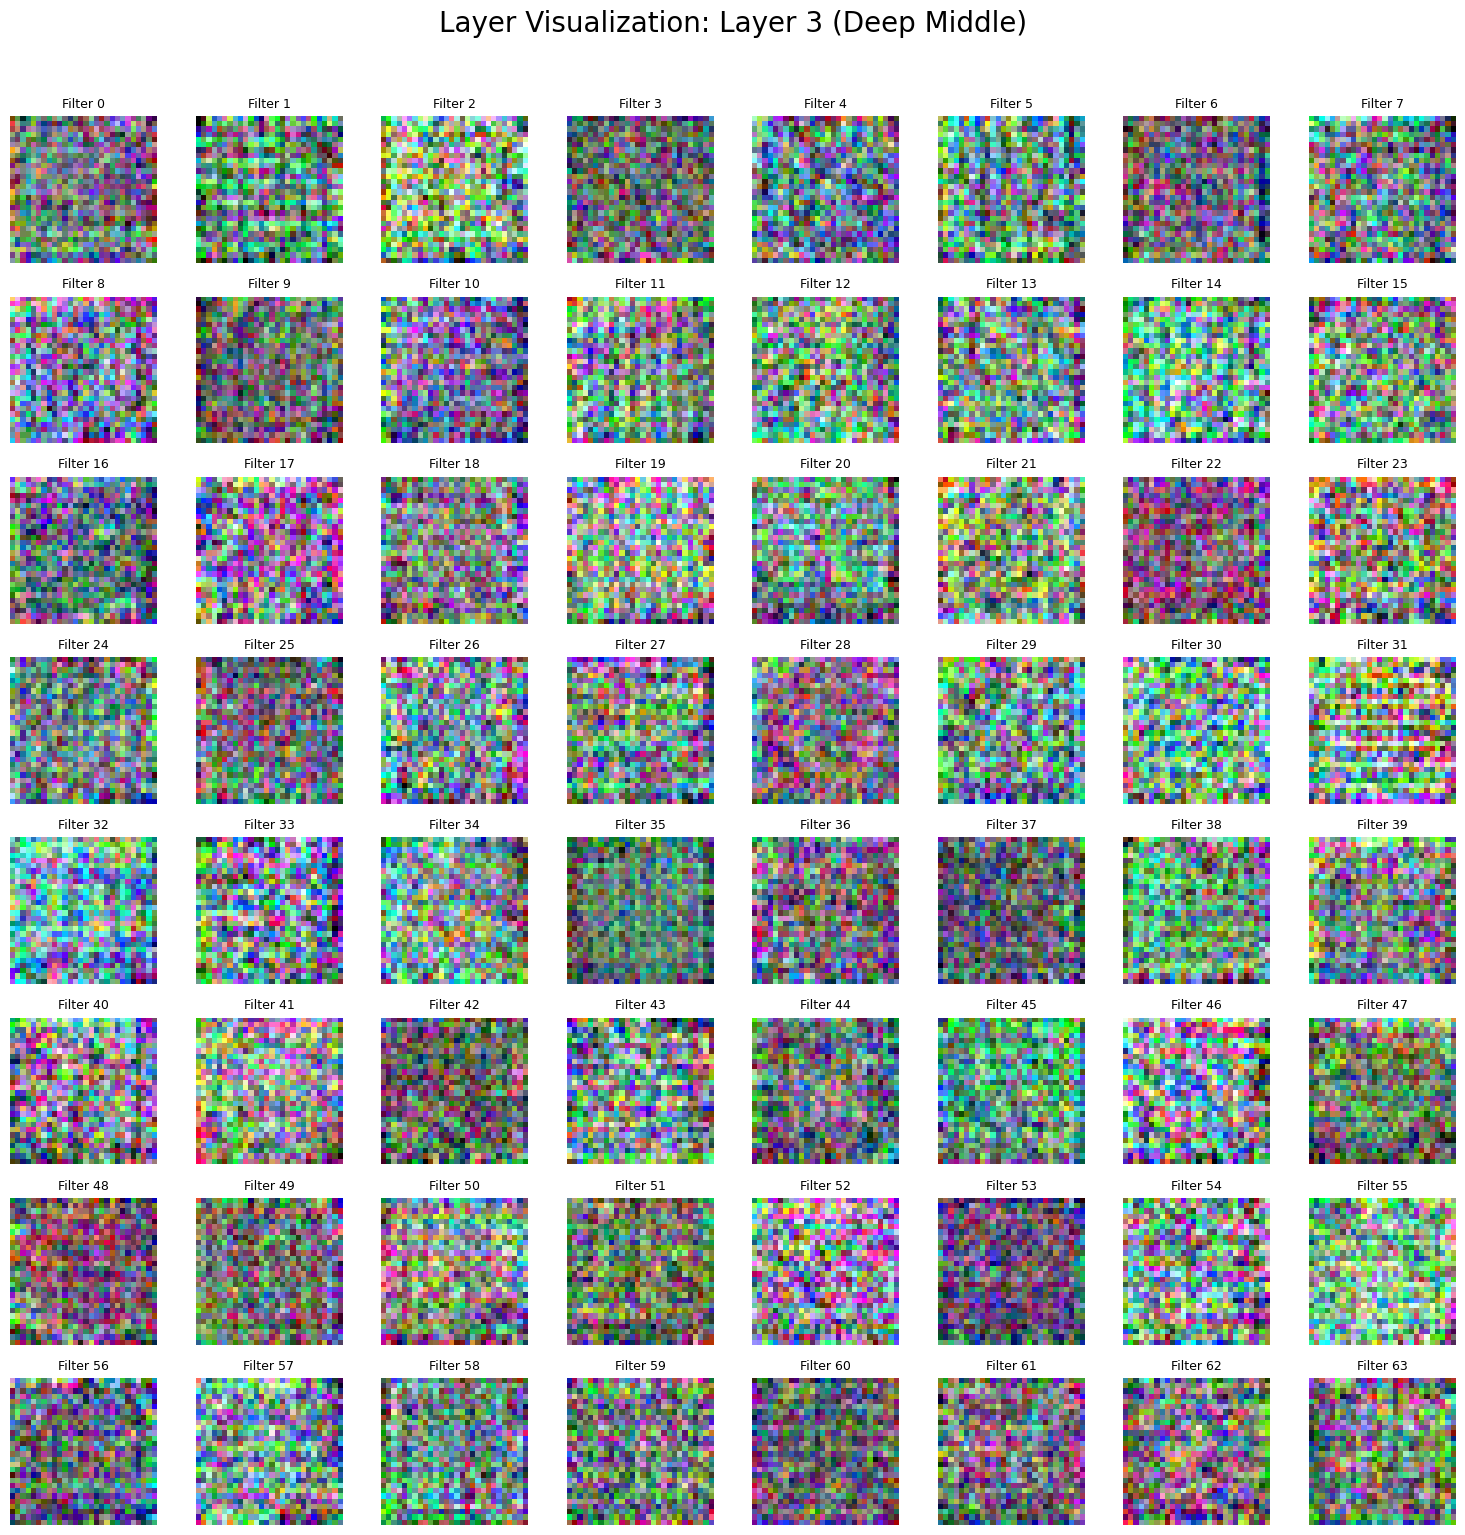

Finished Layer 3 (Deep Middle).

Processing Layer 4 (Output)...
First 64 filters out of 512 total filters:


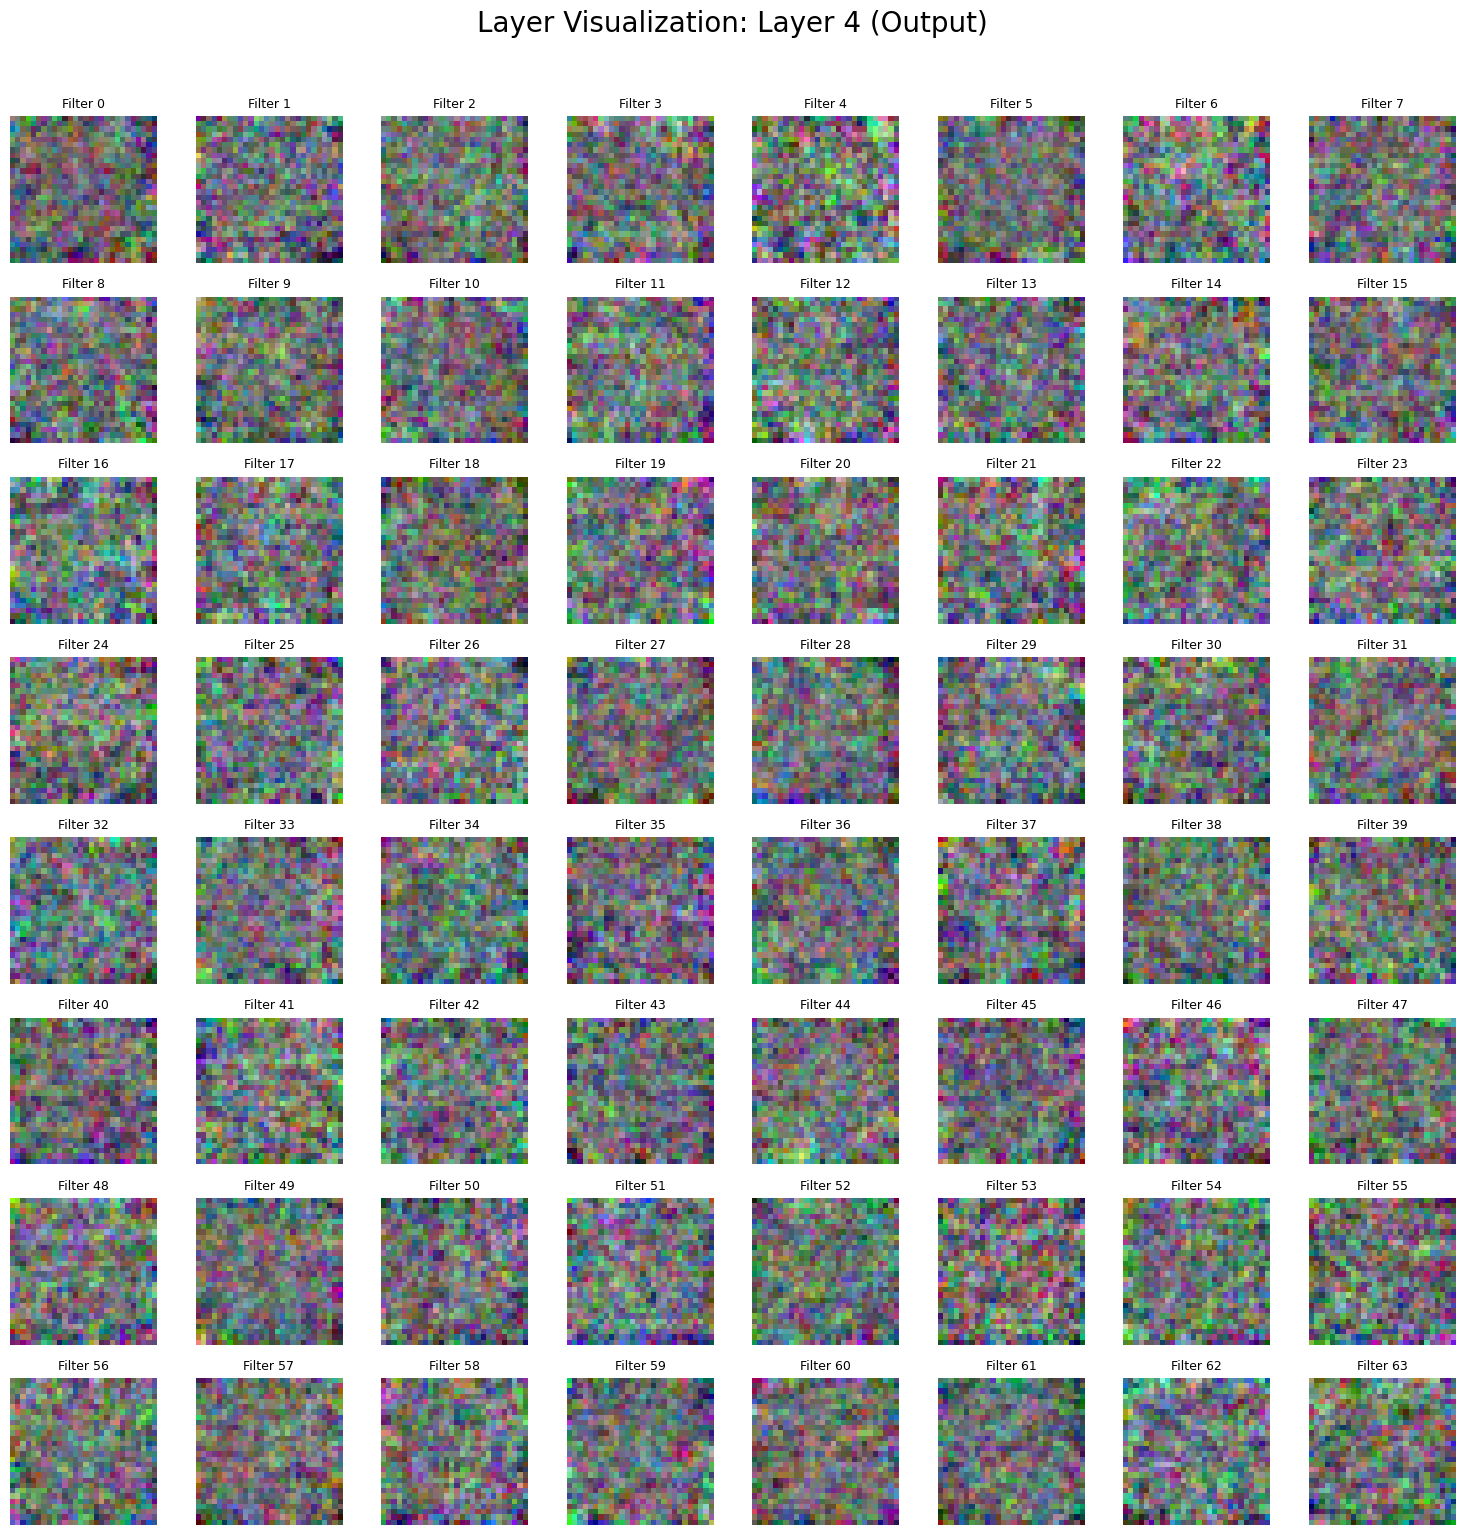

Finished Layer 4 (Output).


In [18]:
visualise_all_layers(model, False)


--- Starting Initial Visualization Scan ---

Processing Layer 1 (Input)...
First 64 filters out of 64 total filters:


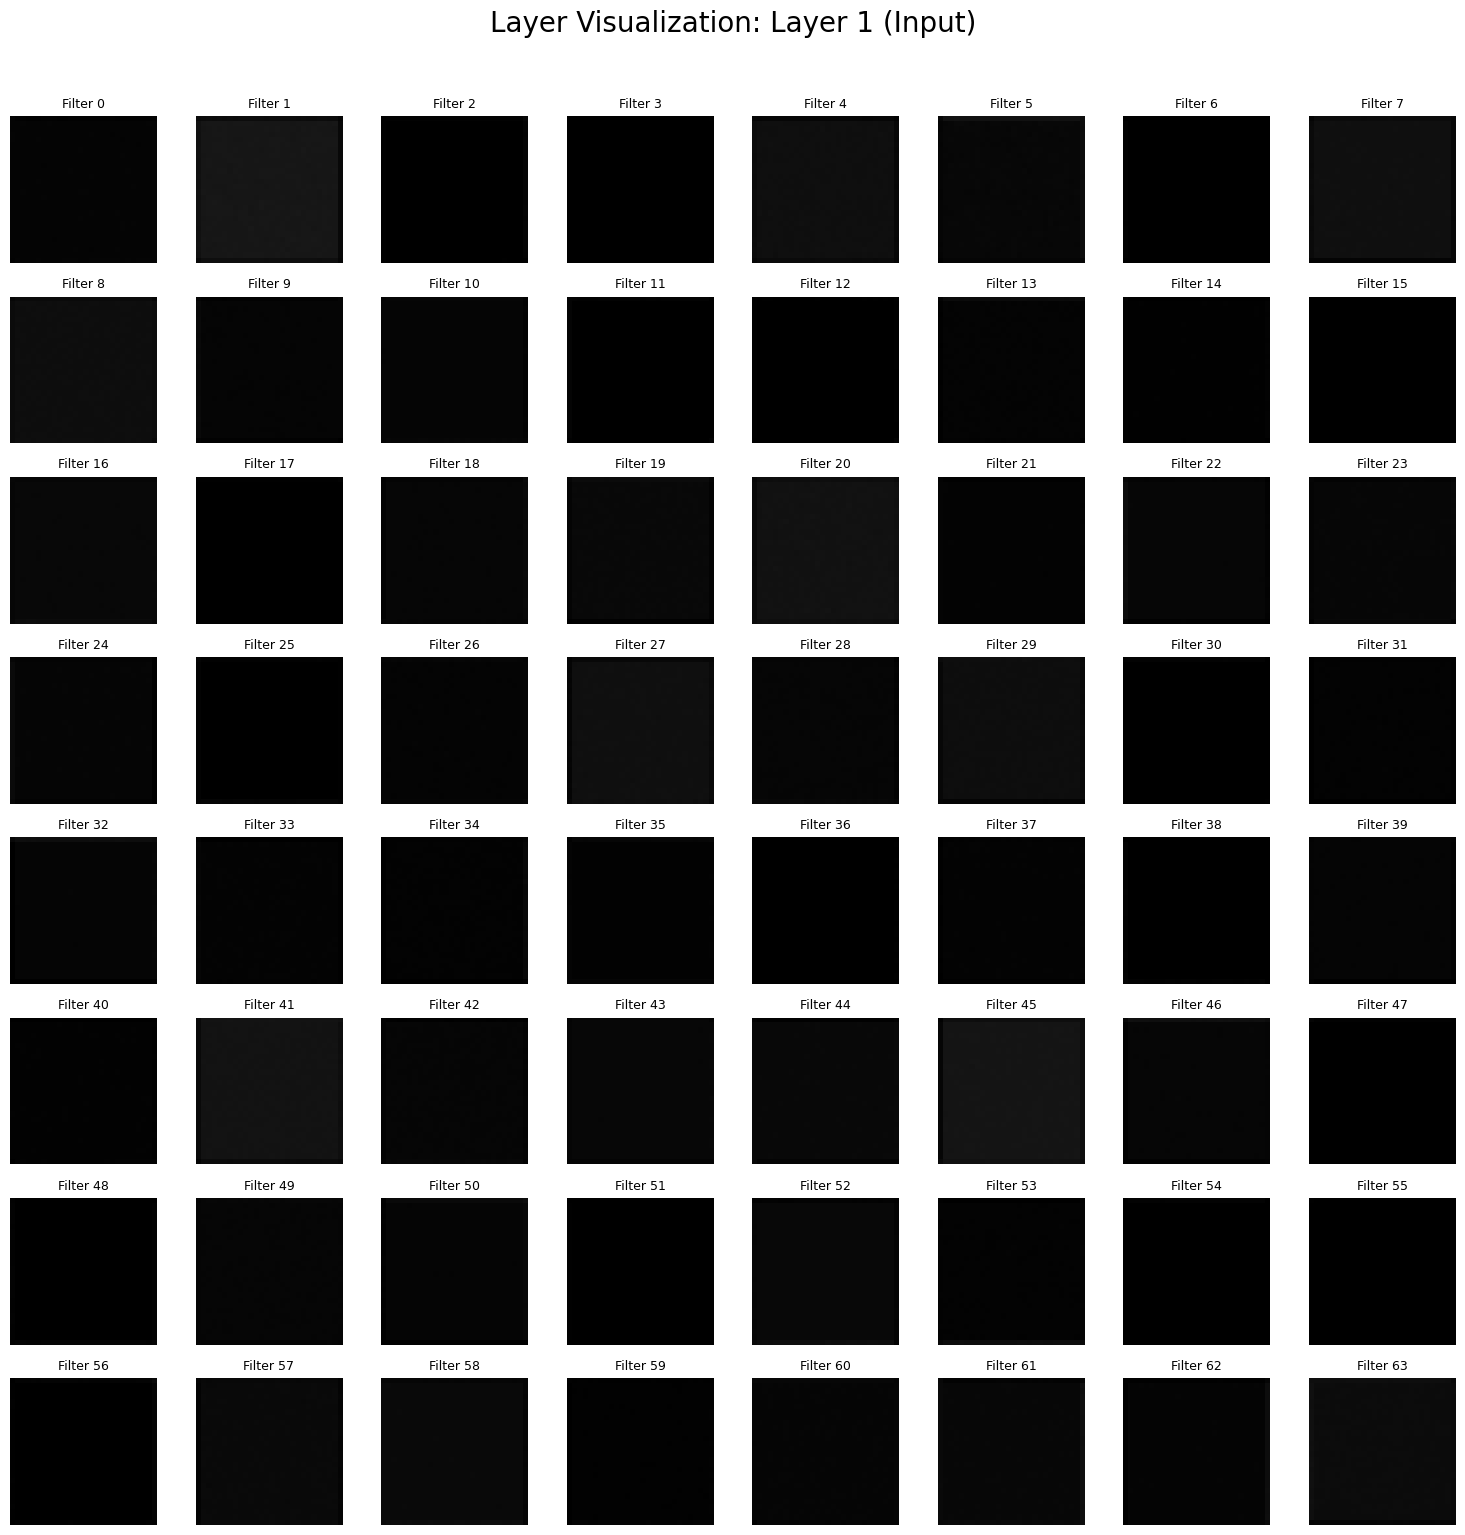

Finished Layer 1 (Input).

Processing Layer 2 (Middle)...
First 64 filters out of 128 total filters:


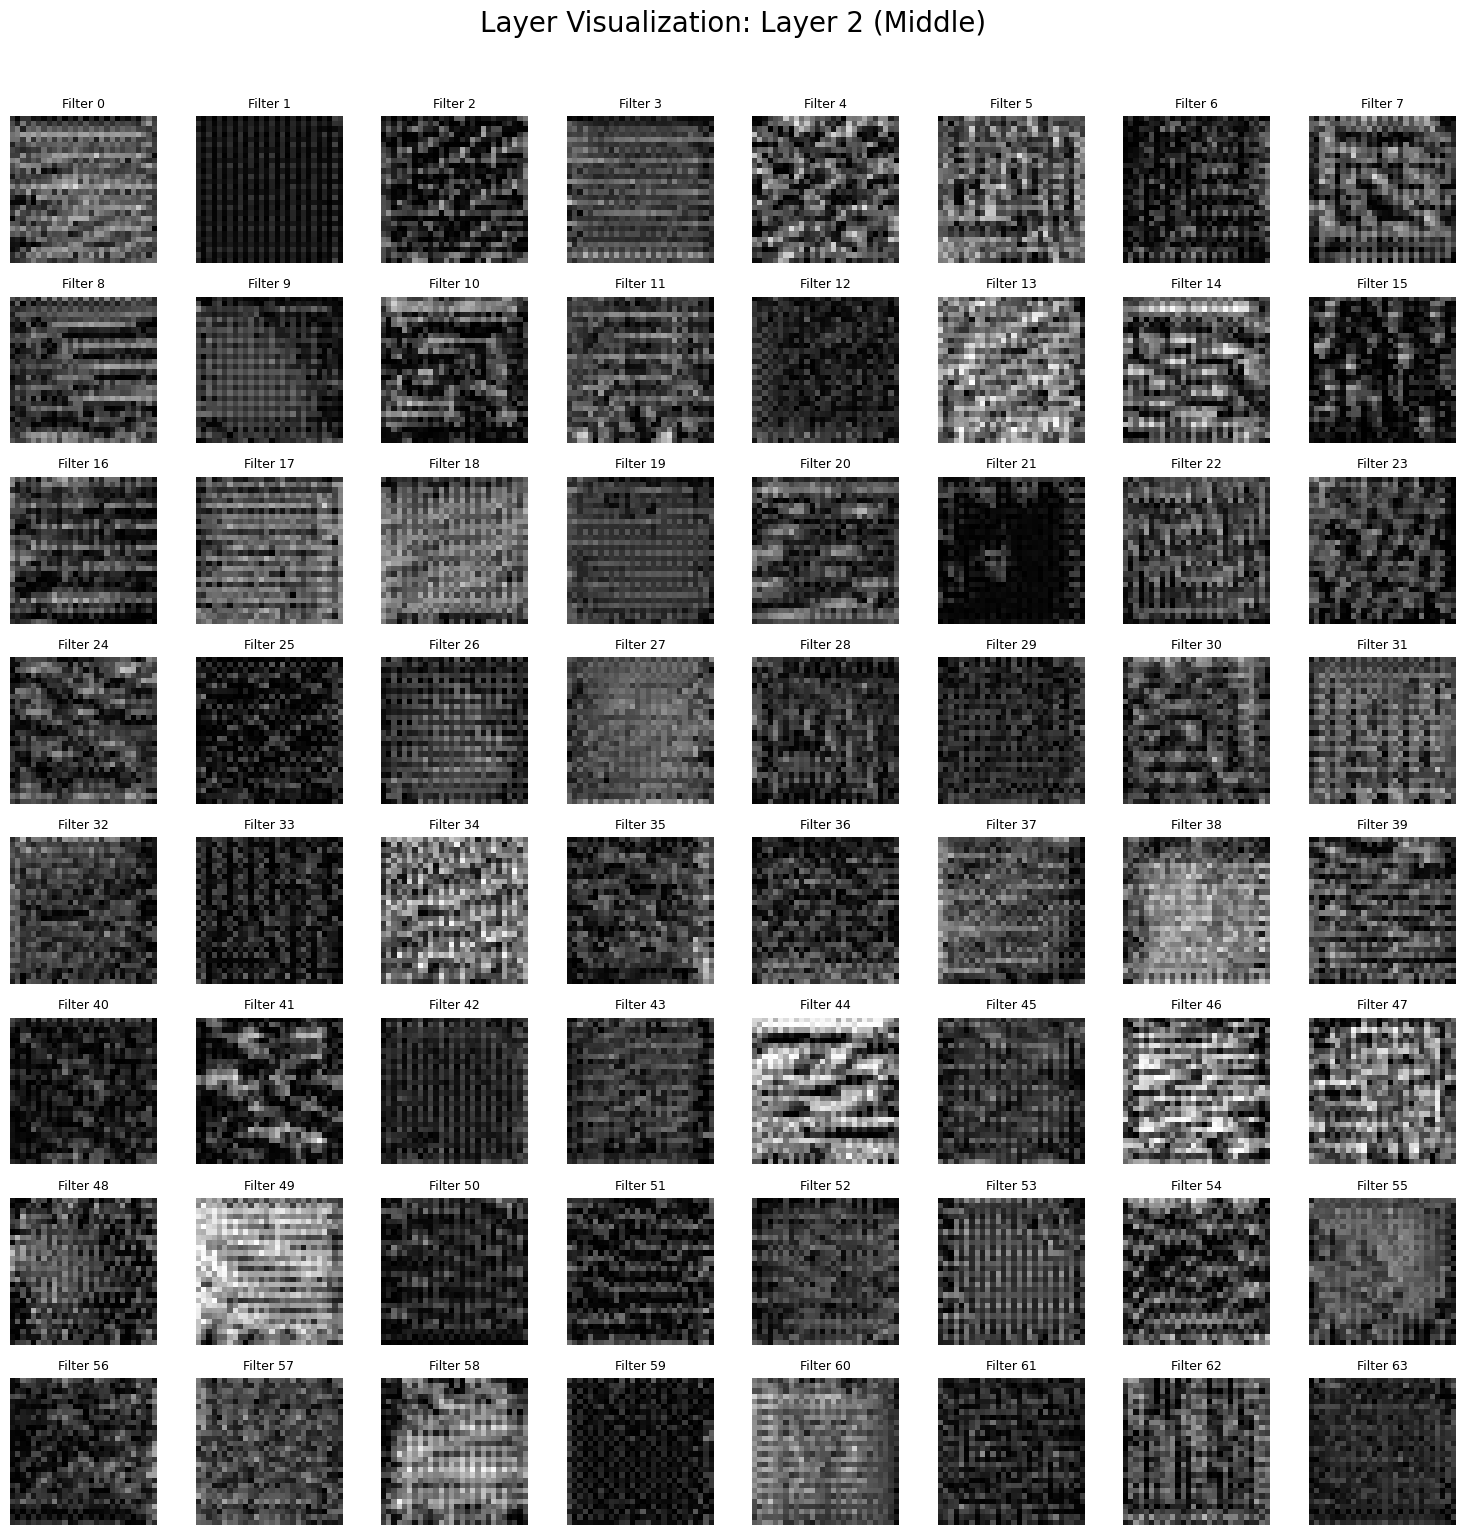

Finished Layer 2 (Middle).

Processing Layer 3 (Deep Middle)...
First 64 filters out of 256 total filters:


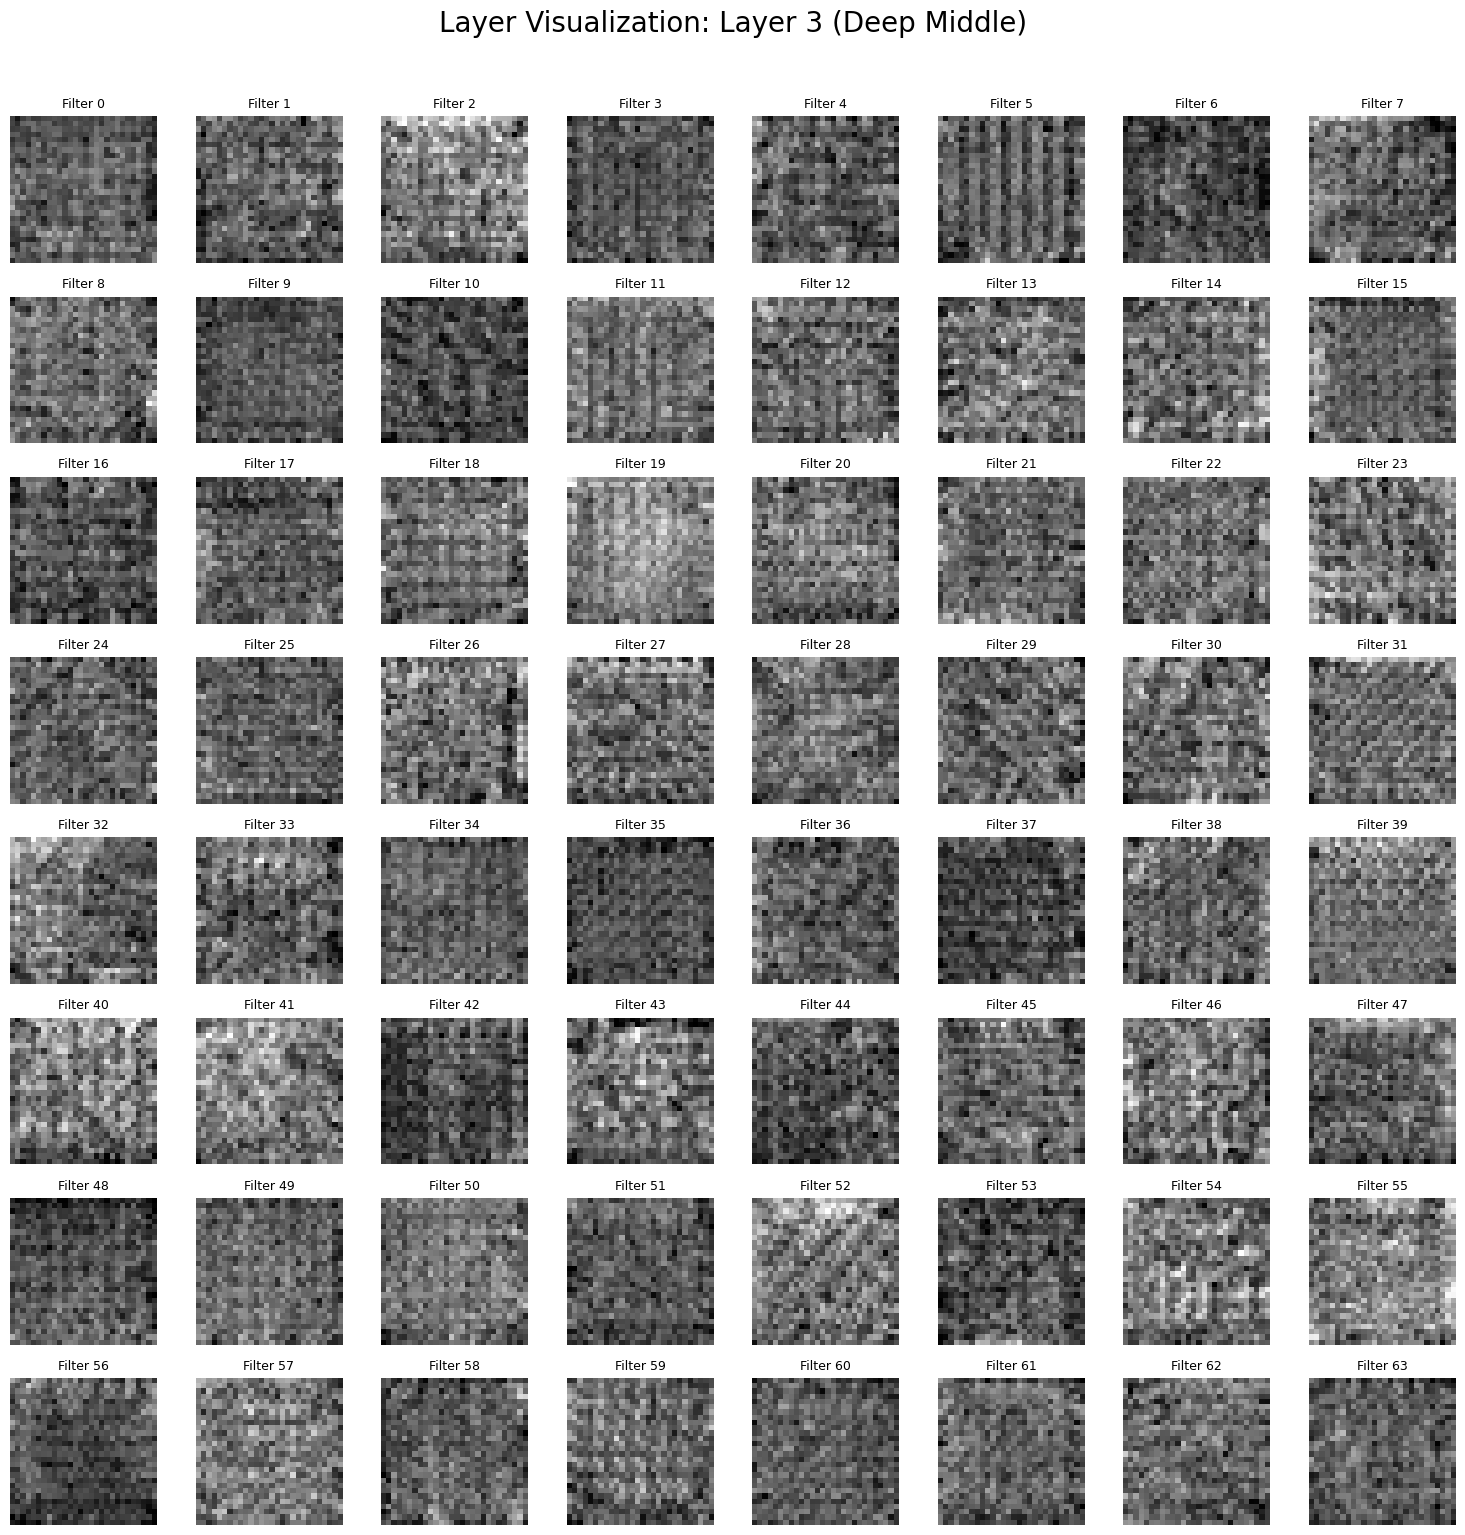

Finished Layer 3 (Deep Middle).

Processing Layer 4 (Output)...
First 64 filters out of 512 total filters:


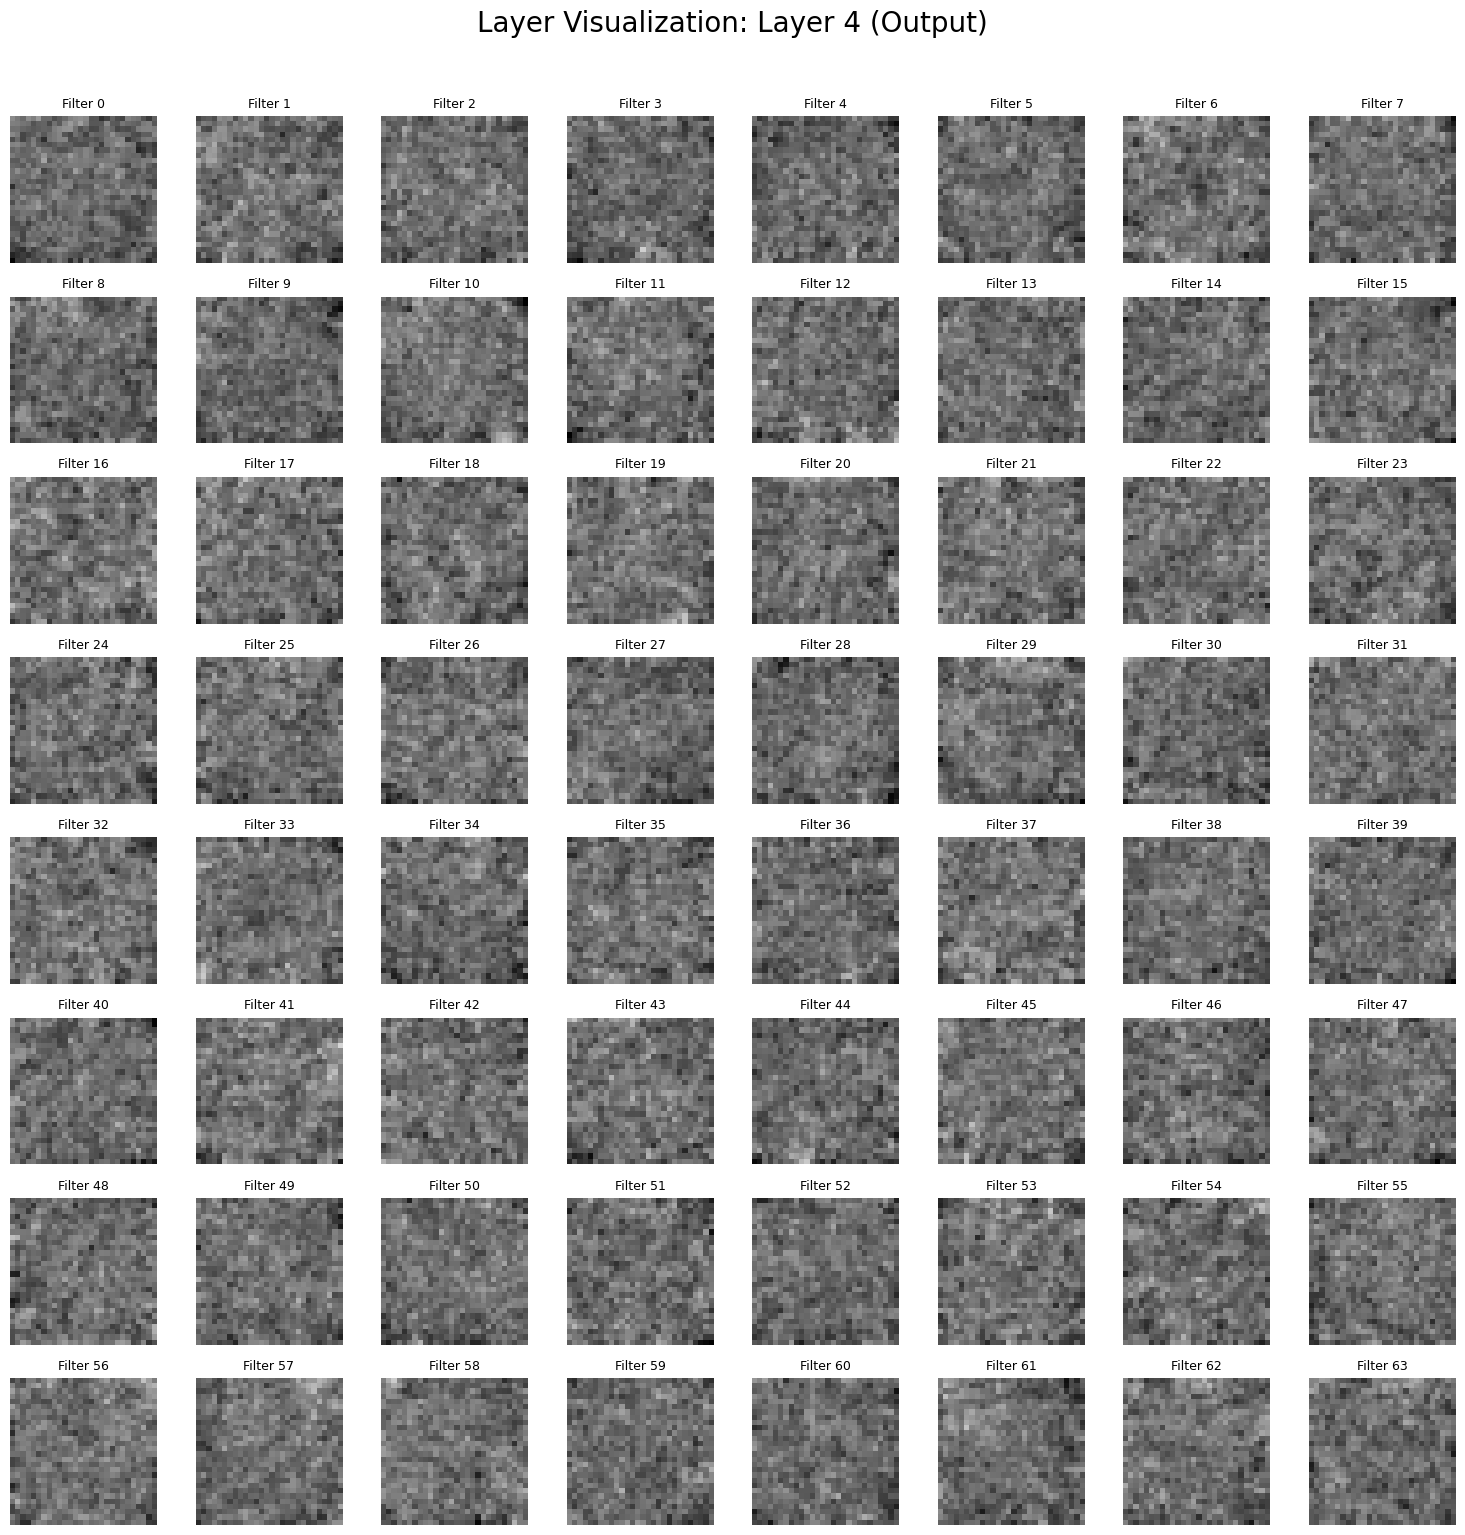

Finished Layer 4 (Output).


In [19]:
# this fixes the visualisations to grayscale
# offers an easier eye test comparison to the control model
visualise_all_layers(model, True)

To compare and interpret these visualisation results, we train a control model on the standard FashionMNIST dataset while keeping the batch size, learning rate and epoch count the same. This model obtains >80% accuracy on the validation and test datasets.

We proceed to visualise what images maximally activate the neurons in this control model, so as to be able to interpret the visualisation for our lazy model.

In [20]:
control = create_model()

transform_control = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) 
])

c_alltrain = datasets.FashionMNIST(root='./control', train=True, transform=transform_control, download=True)
c_train_size = int(0.8 * len(c_alltrain))
c_valid_size = len(c_alltrain) - c_train_size
c_train, c_valid = random_split(c_alltrain, [c_train_size, c_valid_size])
c_test = datasets.FashionMNIST(root='./control', train=False, transform=transform_control, download=True)

c_batchsize = 300
c_learningrate = 0.00001
c_epochs = 2

c_trainloader = DataLoader(c_train, batch_size=c_batchsize, shuffle=True)
c_validloader = DataLoader(c_valid, batch_size=c_batchsize, shuffle=False)
c_testloader = DataLoader(c_test, batch_size=c_batchsize, shuffle=False)

In [21]:
c_crit = nn.CrossEntropyLoss()
c_optimiser = optim.Adam(control.parameters(), lr=c_learningrate)

def train_control():
    # training loop
    for epoch in range(c_epochs):
        control.train()
        # running loss is the cumulative loss across batches as a model trains over one epoch
        runningloss = 0.0
        # to display progress bar (for model training)
        loop = tqdm(c_trainloader, desc=f"Epoch {epoch+1}/{c_epochs}")
        
        for images, labels in loop:
            # load images and labels onto the GPU, where the model is
            images, labels = images.to(device), labels.to(device)
            # flush/clear all gradients
            c_optimiser.zero_grad()
            # run the CNN on the image set to get the output classes (forward pass)
            outputs = control(images)
            # loss fn compares output classes with input labels
            loss = c_crit(outputs, labels)
            # backpropagation
            loss.backward()
            # optimising weights accordingly
            c_optimiser.step()
    
            runningloss += loss.item()
            # updates the progress bar
            loop.set_postfix(loss=loss.item())
    
    accu_vali = evaluate_model(control, c_validloader, "Accuracy on easy set (biased)")
    accu_test = evaluate_model(control, c_testloader, "Accuracy on difficult set (conflict)")
    
    torch.save(control.state_dict(), "./FashionMNIST/controlmodel.pth")

In [22]:
train_control()

Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:39<00:00,  4.08it/s, loss=0.524]


Accuracy on easy set (biased):  82.61%
Accuracy on difficult set (conflict):  81.66%


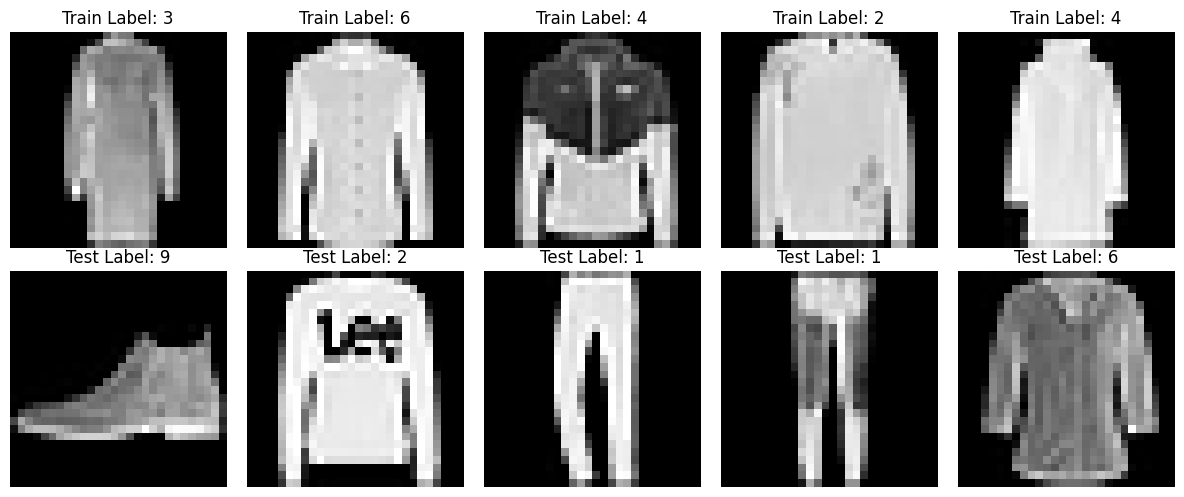

In [23]:
# just to see what kind of data is in the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
        image, label = c_train[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        c_imtrain = image.permute(1, 2, 0).numpy()
        axes[0, i].imshow(c_imtrain)
        axes[0, i].set_title(f"Train Label: {label}")
        axes[0, i].axis('off')

for i in range(5):
        image, label = c_test[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        c_imtest = image.permute(1, 2, 0).numpy()
        axes[1, i].imshow(c_imtest)
        axes[1, i].set_title(f"Test Label: {label}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()


--- Starting Initial Visualization Scan ---

Processing Layer 1 (Input)...
First 64 filters out of 64 total filters:


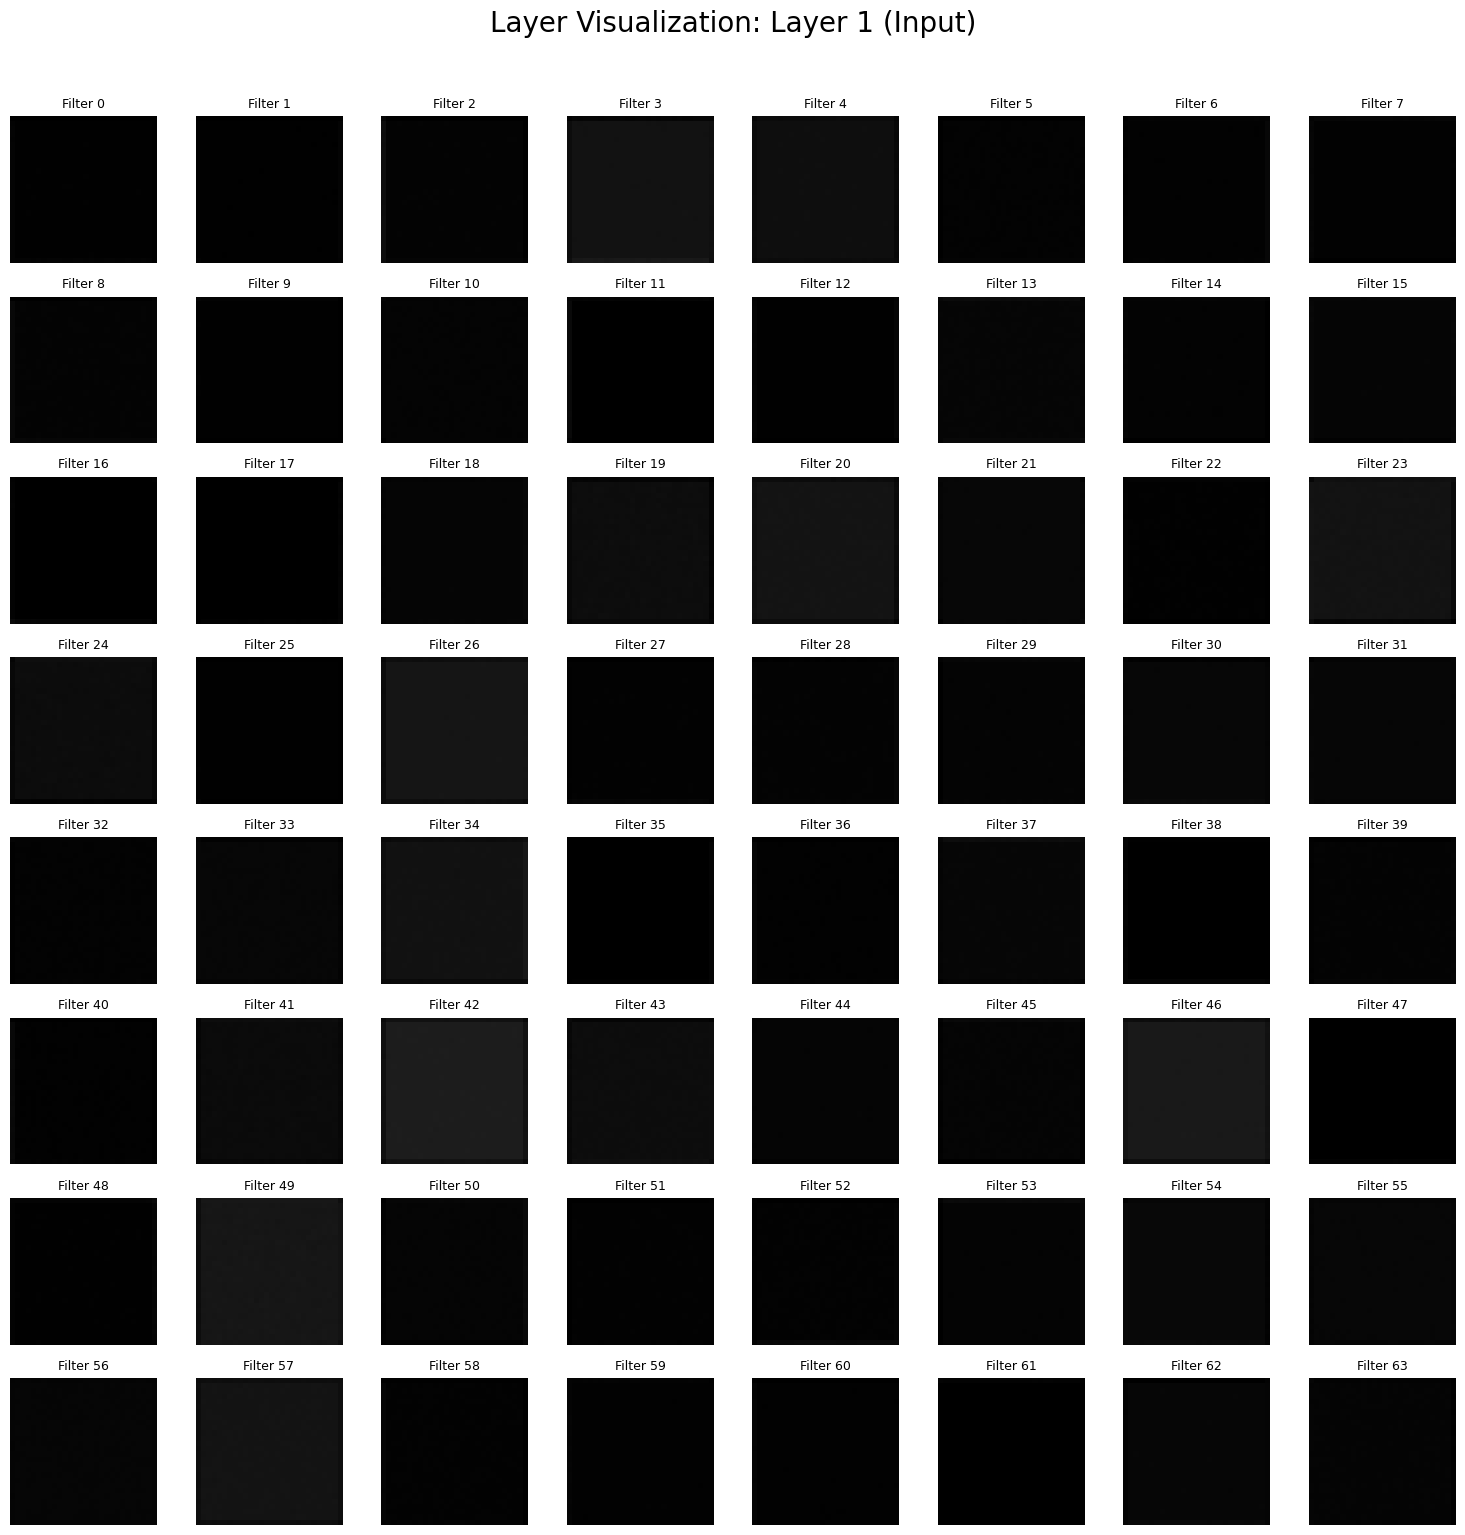

Finished Layer 1 (Input).

Processing Layer 2 (Middle)...
First 64 filters out of 128 total filters:


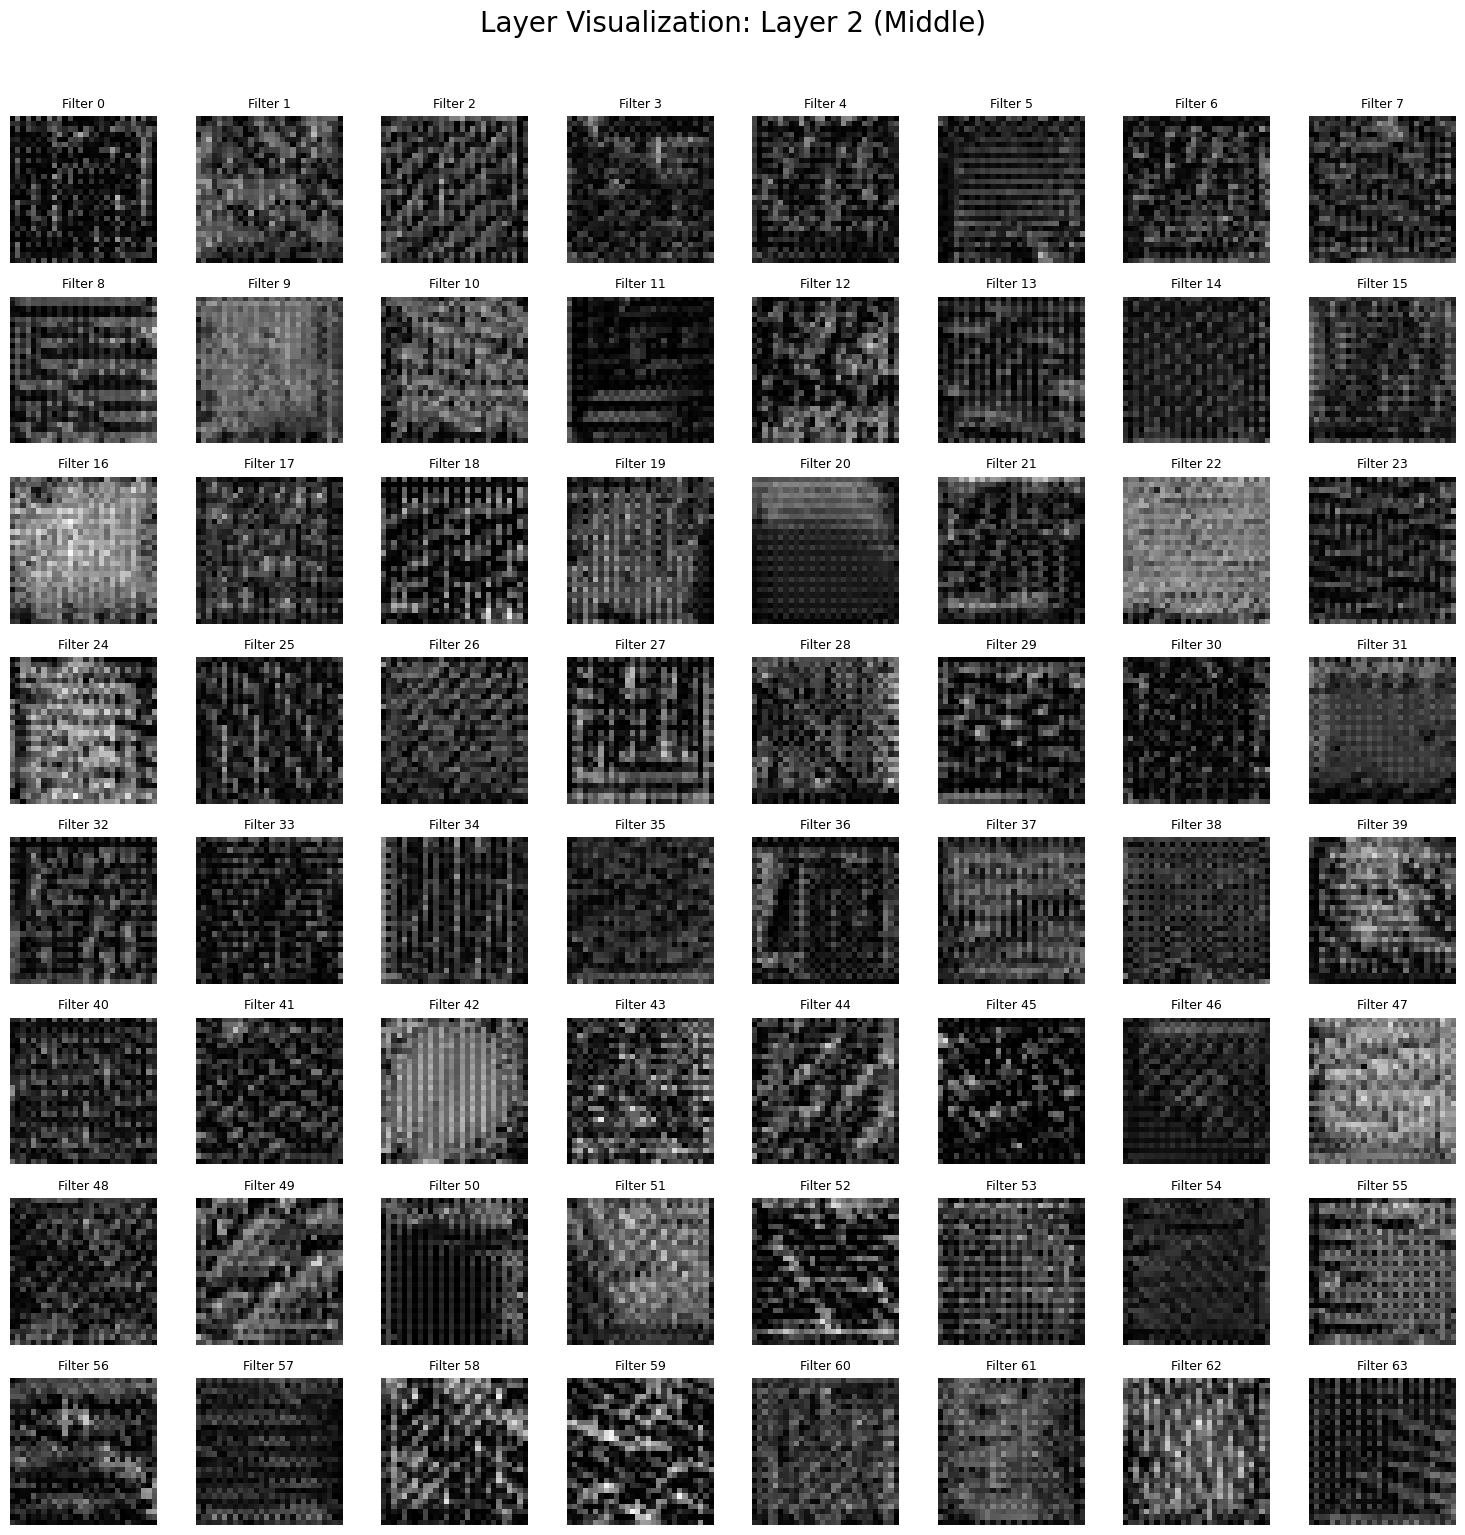

Finished Layer 2 (Middle).

Processing Layer 3 (Deep Middle)...
First 64 filters out of 256 total filters:


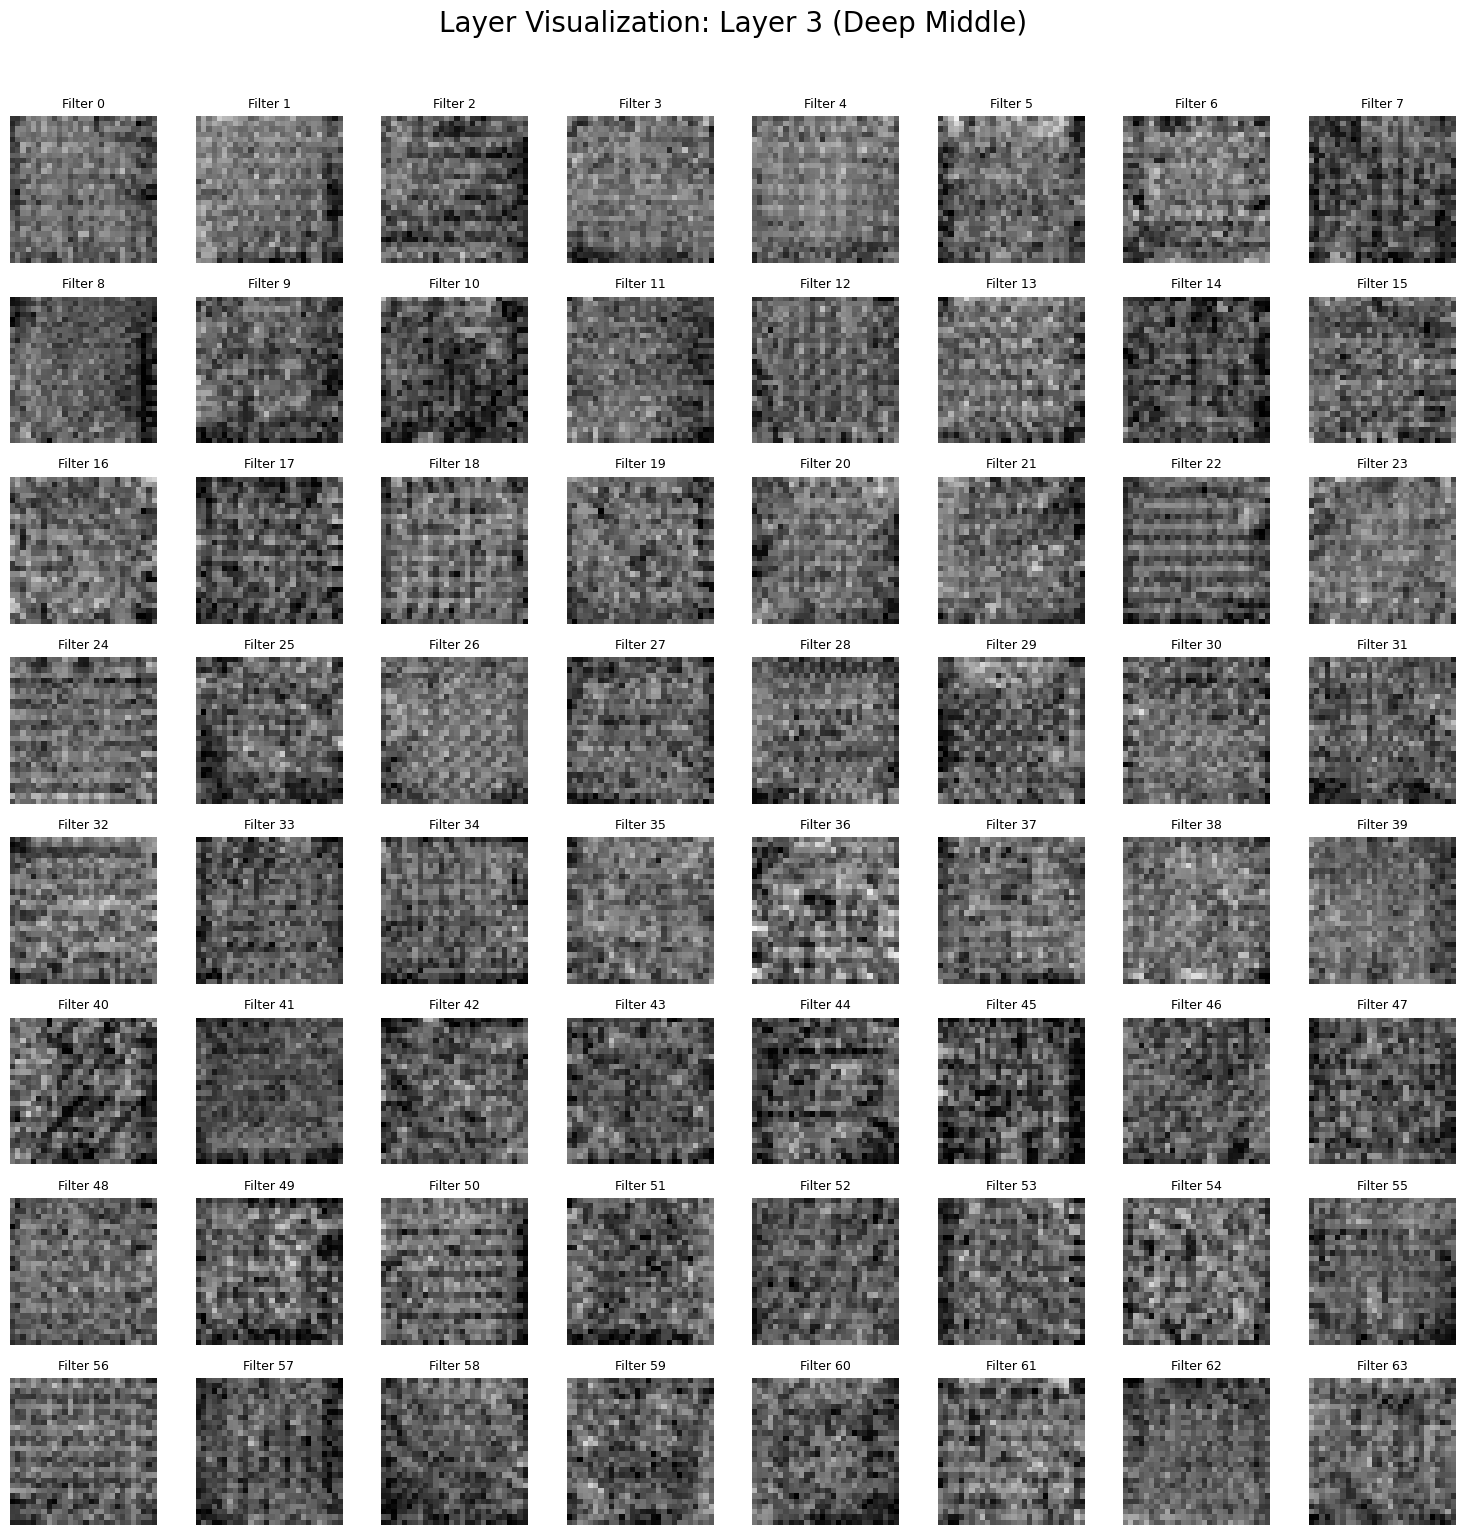

Finished Layer 3 (Deep Middle).

Processing Layer 4 (Output)...
First 64 filters out of 512 total filters:


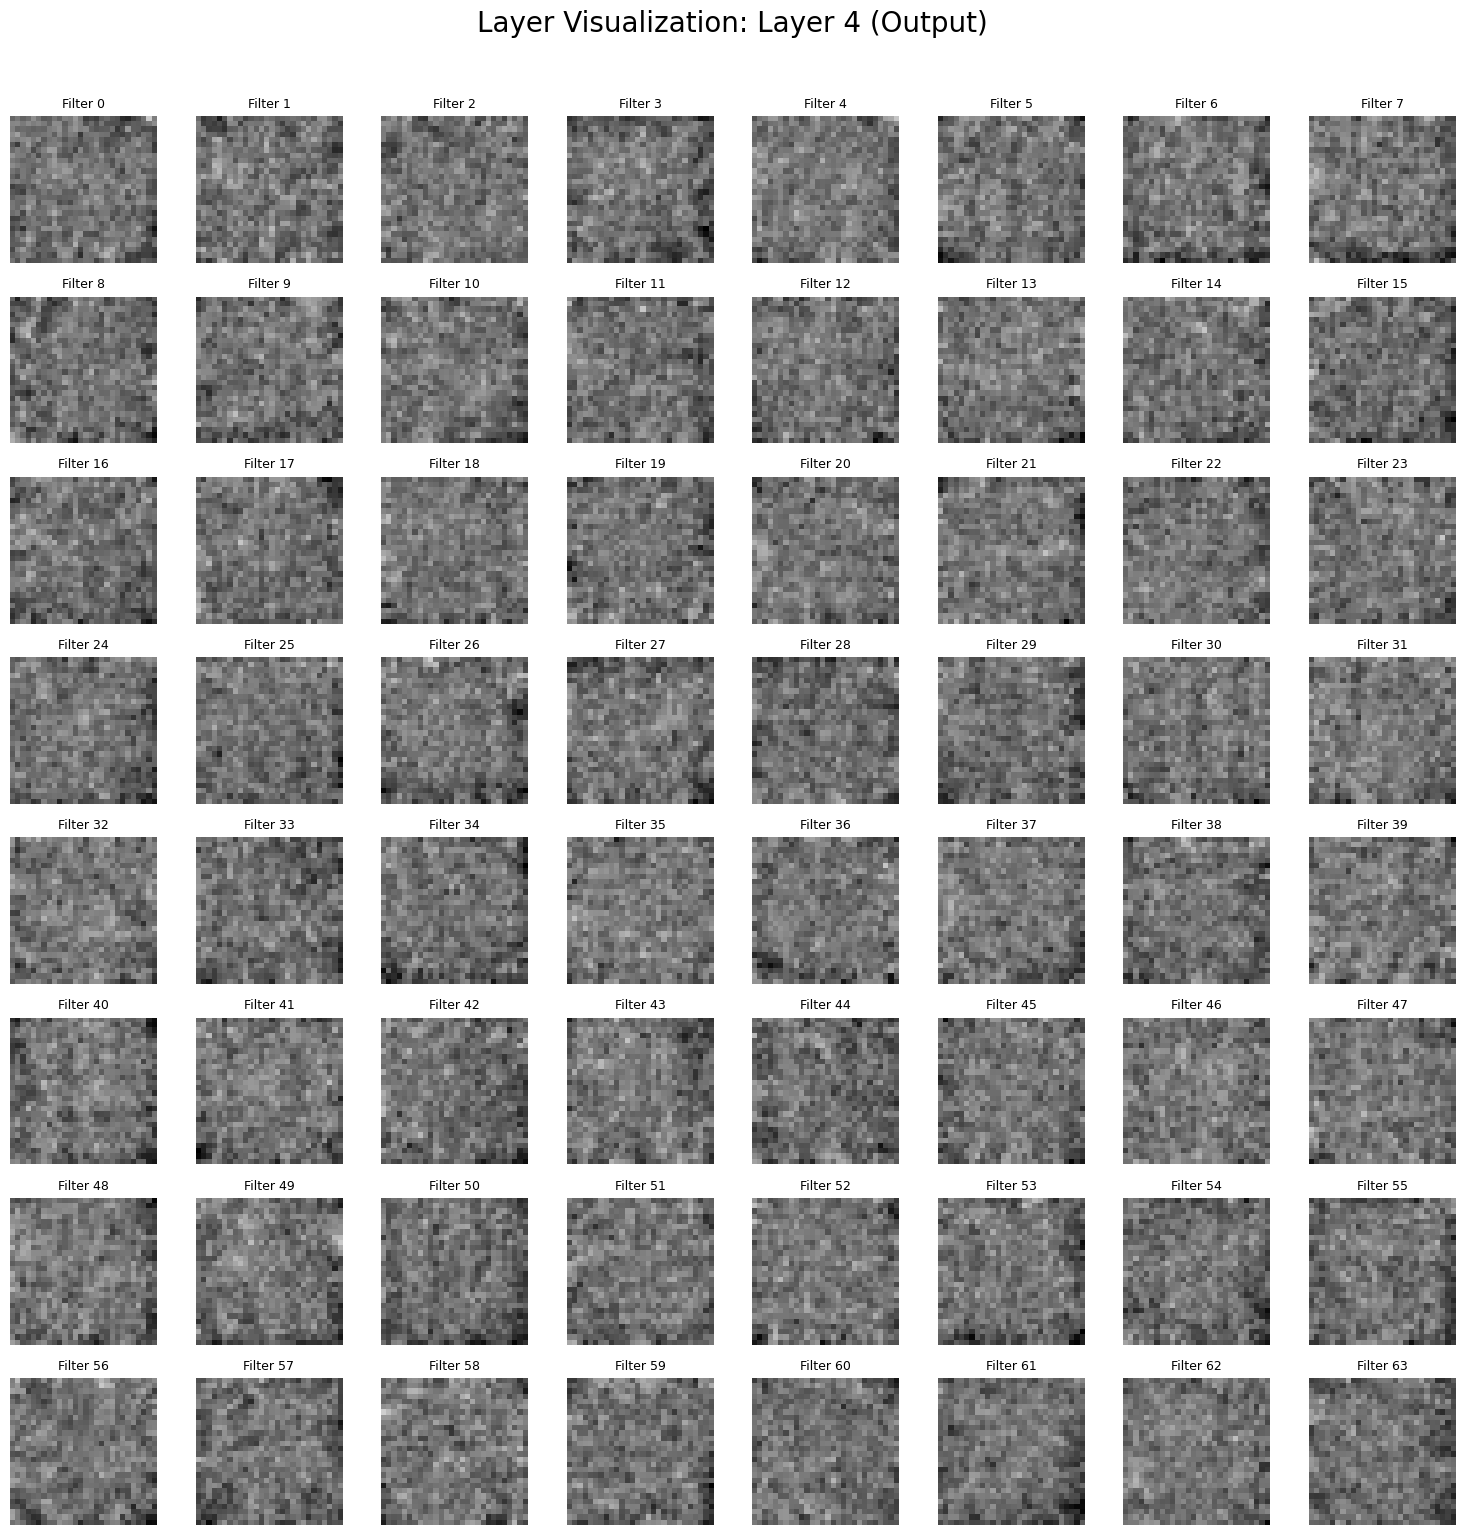

Finished Layer 4 (Output).


In [24]:
visualise_all_layers(control, True)


--- Starting Initial Visualization Scan ---

Processing Layer 1 (Input)...
First 64 filters out of 64 total filters:


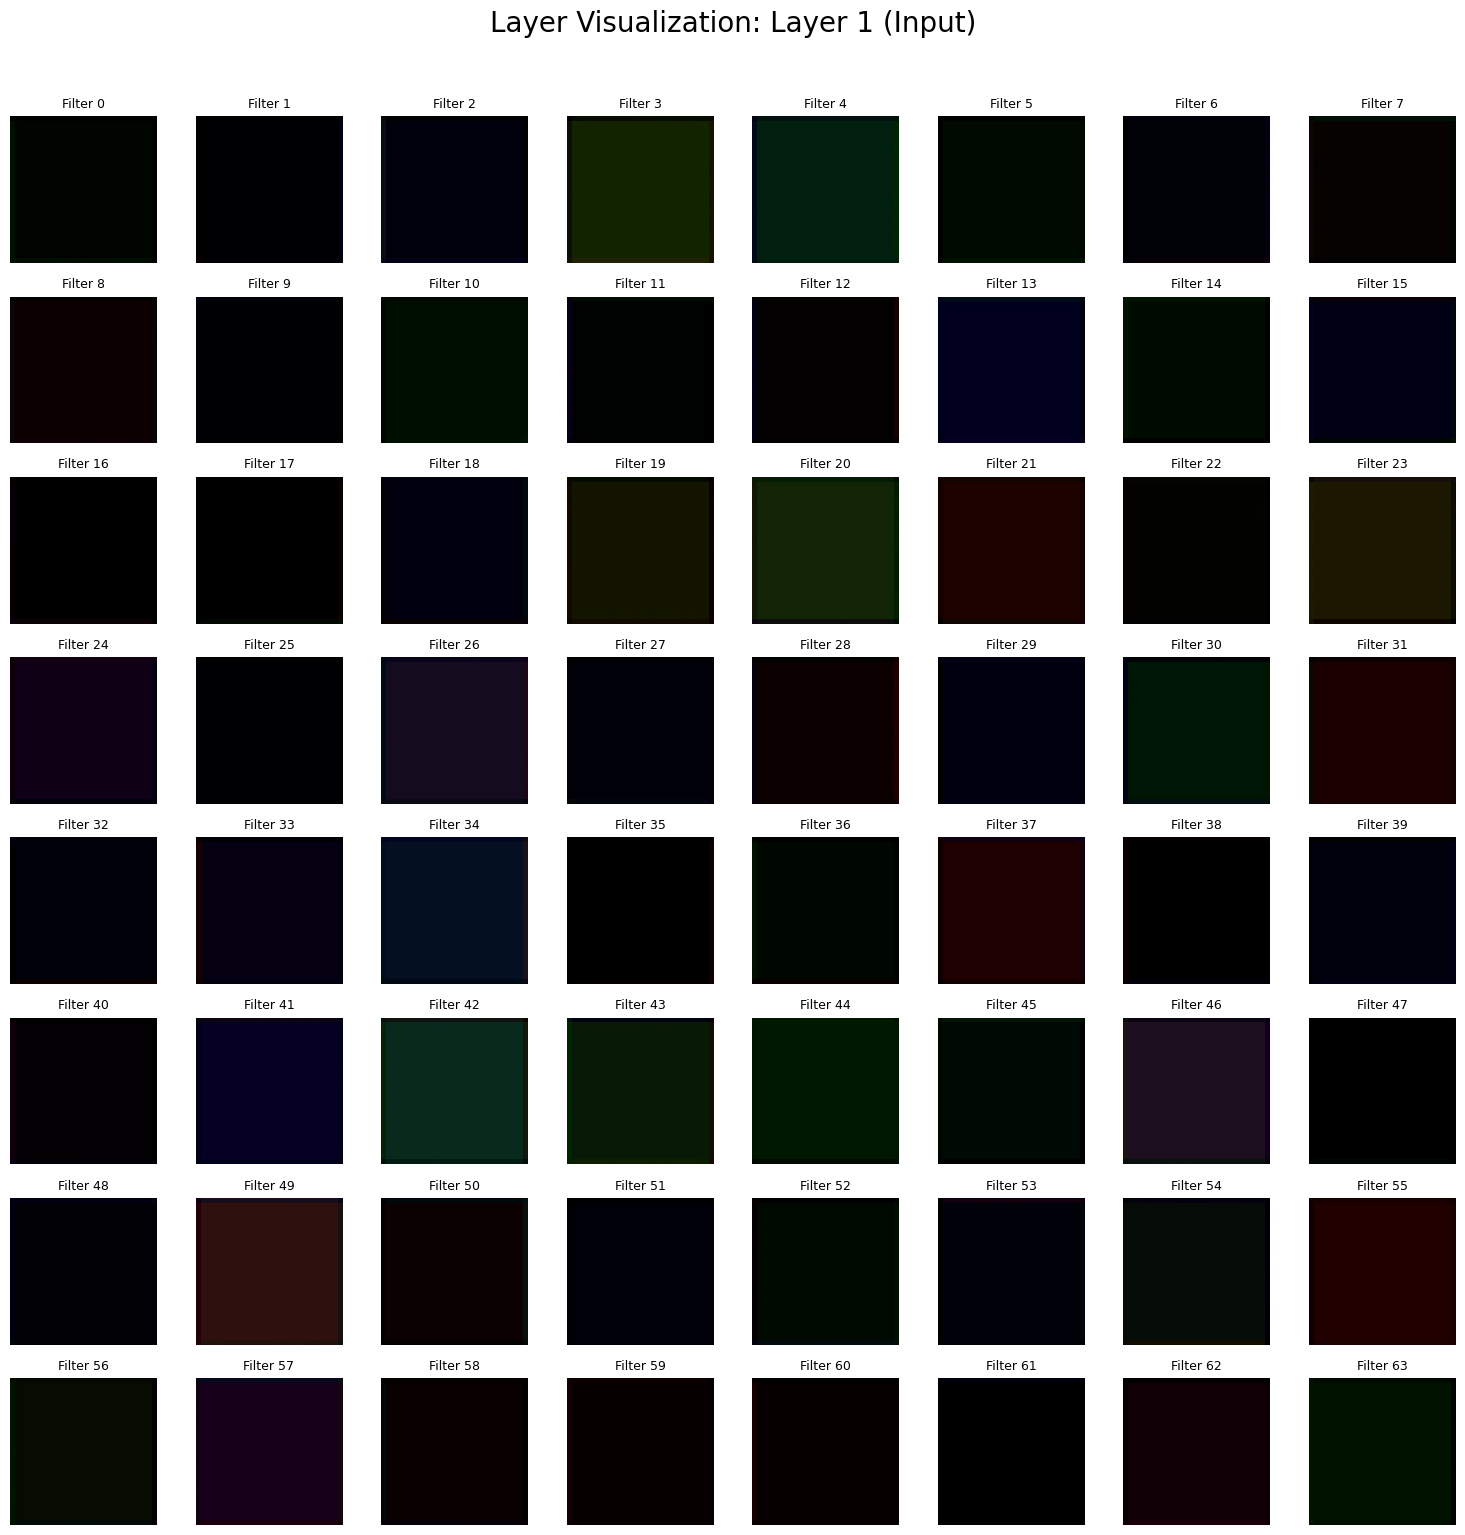

Finished Layer 1 (Input).

Processing Layer 2 (Middle)...
First 64 filters out of 128 total filters:


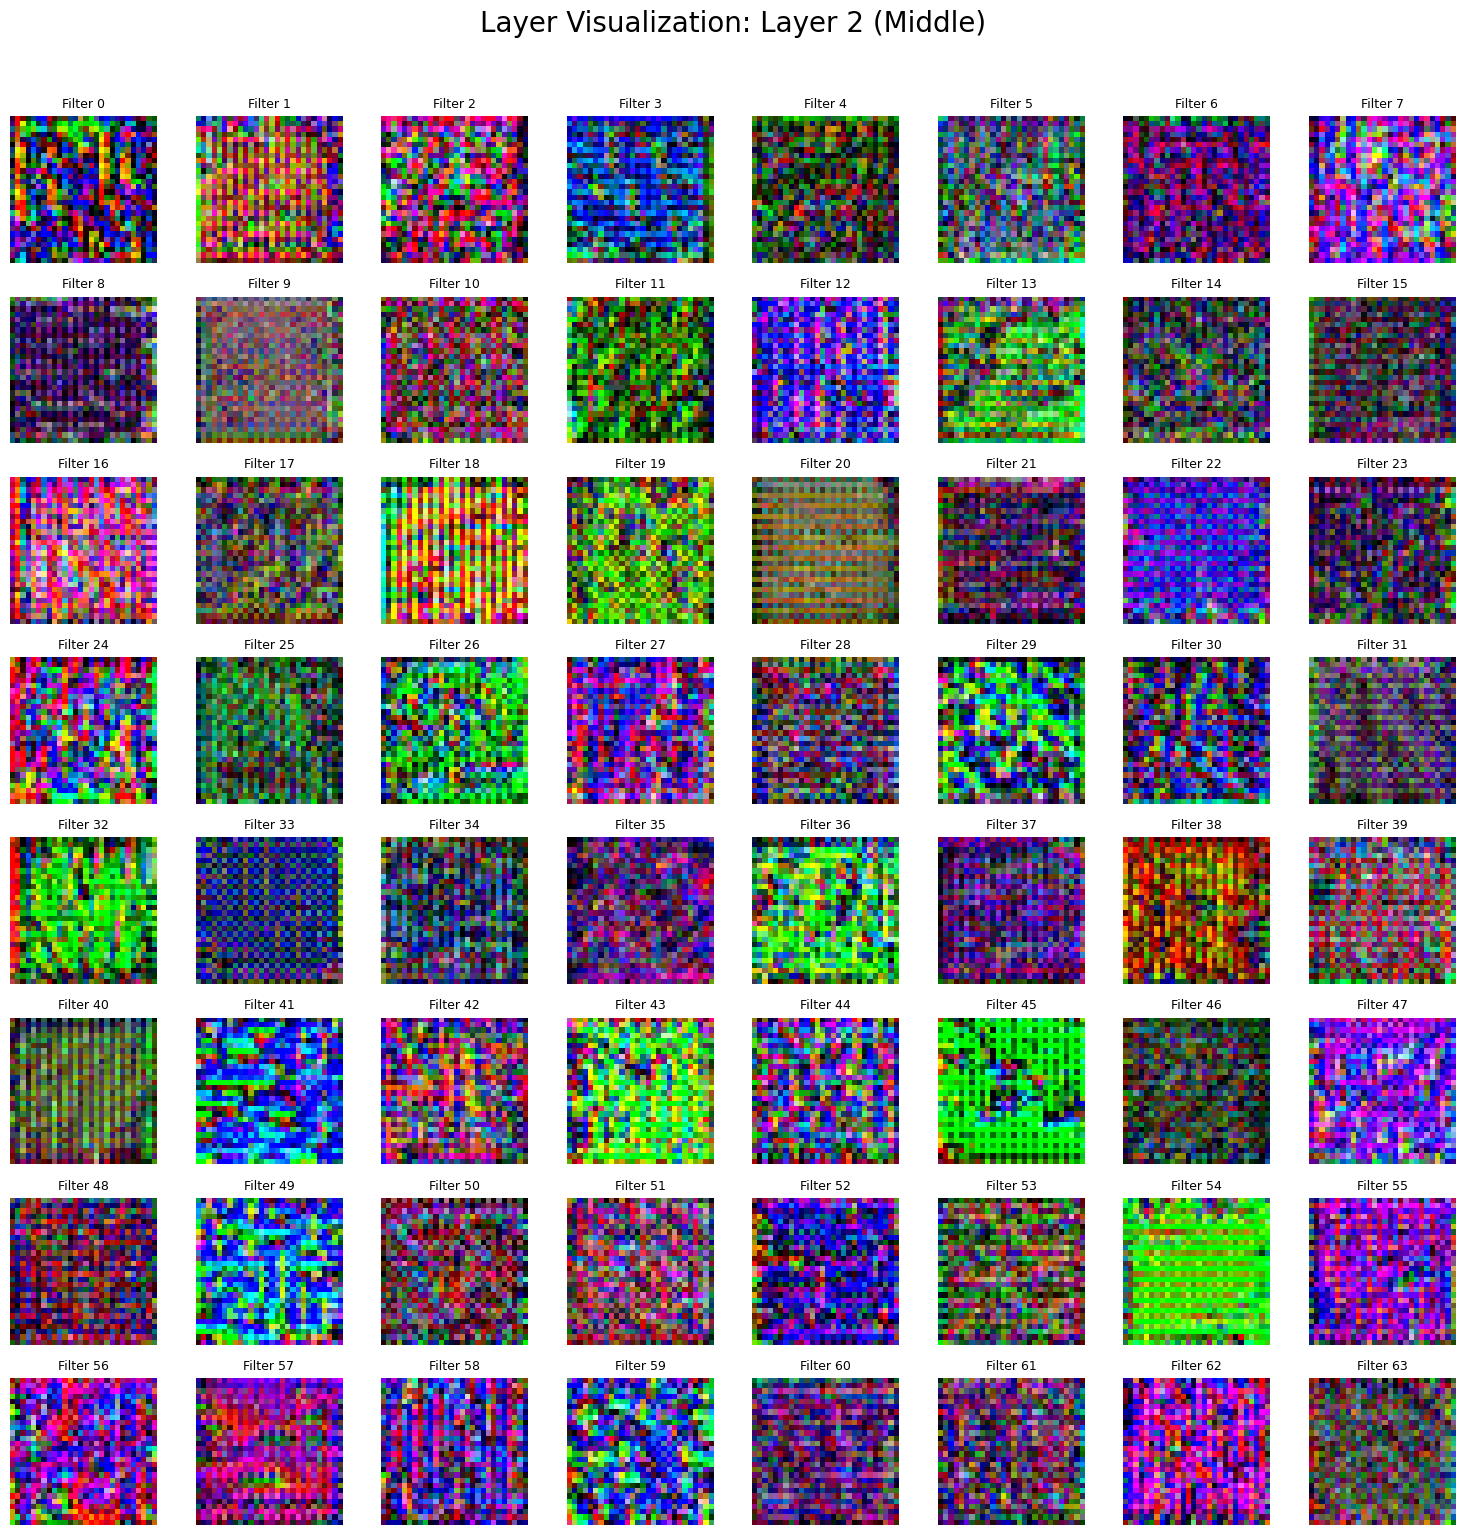

Finished Layer 2 (Middle).

Processing Layer 3 (Deep Middle)...
First 64 filters out of 256 total filters:


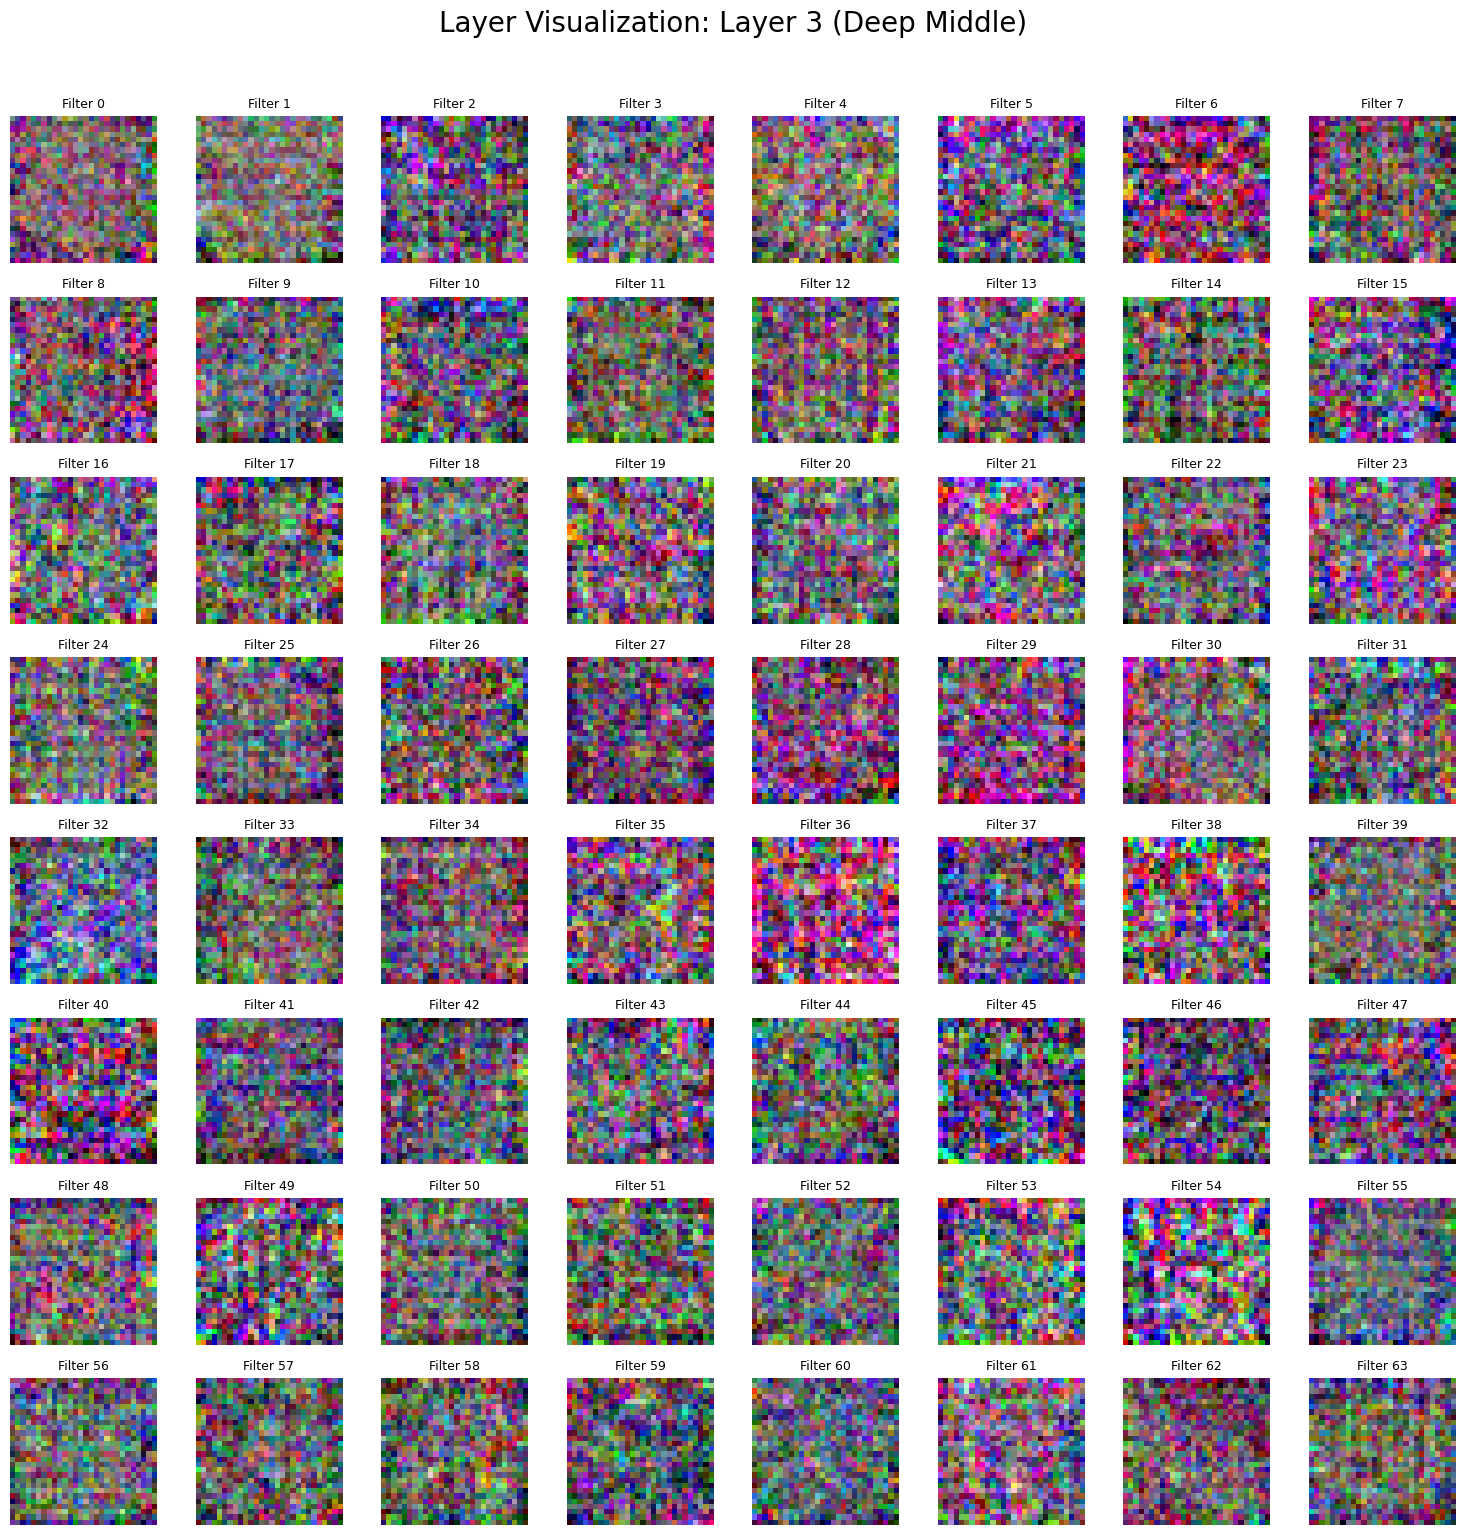

Finished Layer 3 (Deep Middle).

Processing Layer 4 (Output)...
First 64 filters out of 512 total filters:


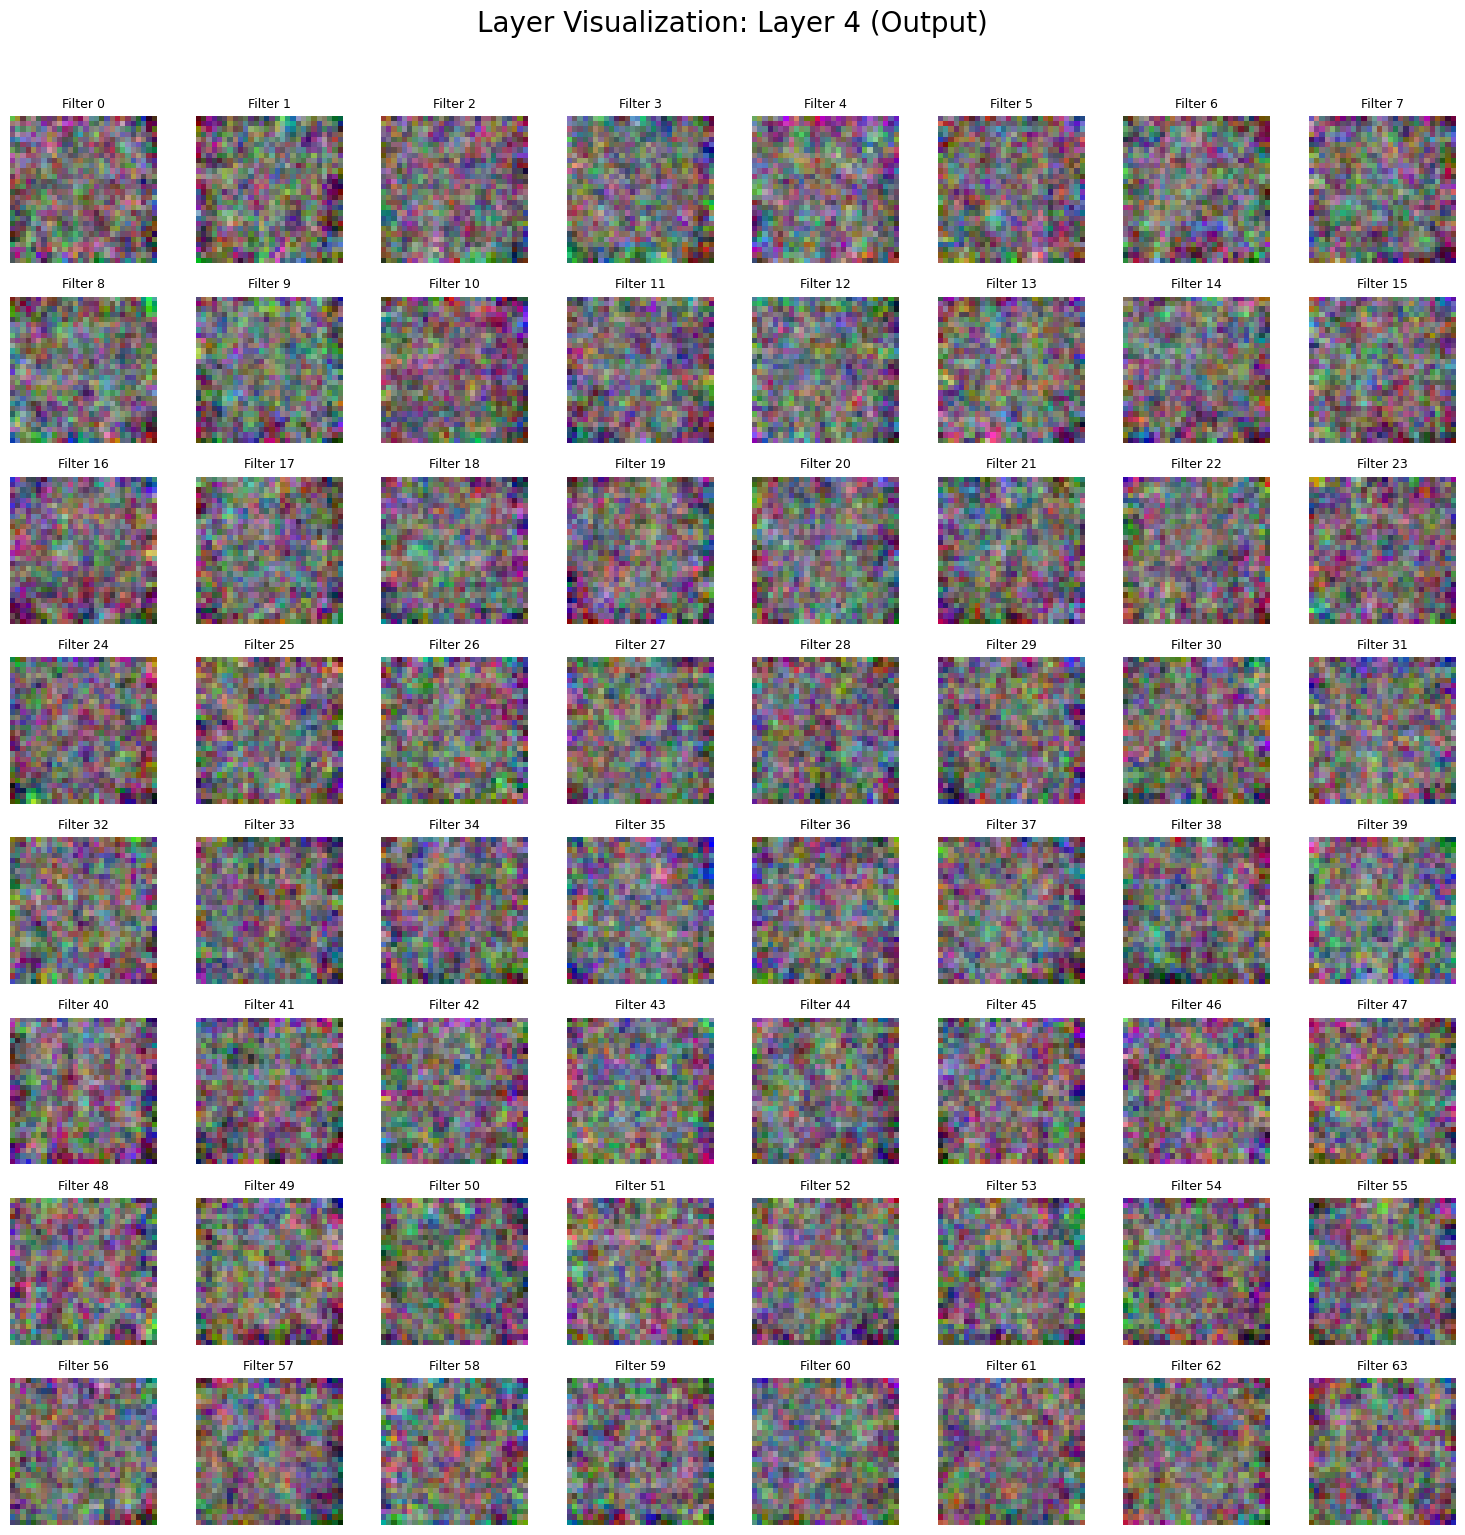

Finished Layer 4 (Output).


In [25]:
# just for comparison to the coloured version of the lazy model
visualise_all_layers(control, False)

Scanning dataset for Neuron 1...


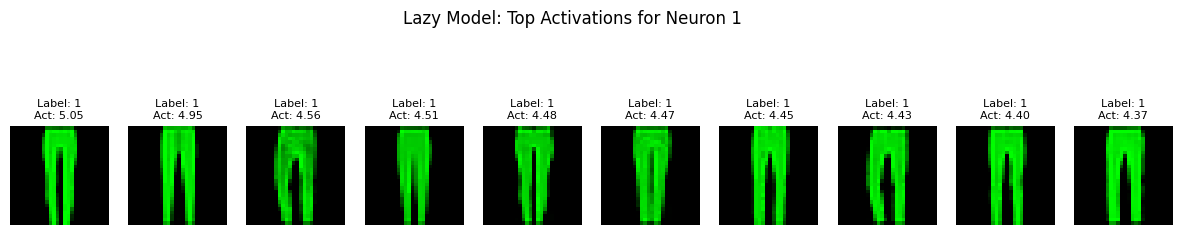

Scanning dataset for Neuron 1...


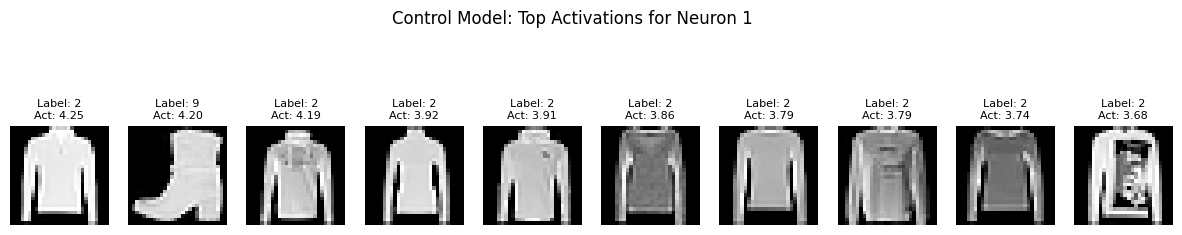

Scanning dataset for Neuron 6...


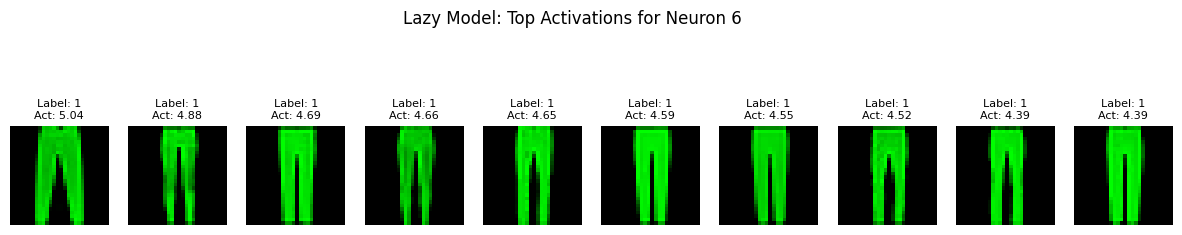

Scanning dataset for Neuron 6...


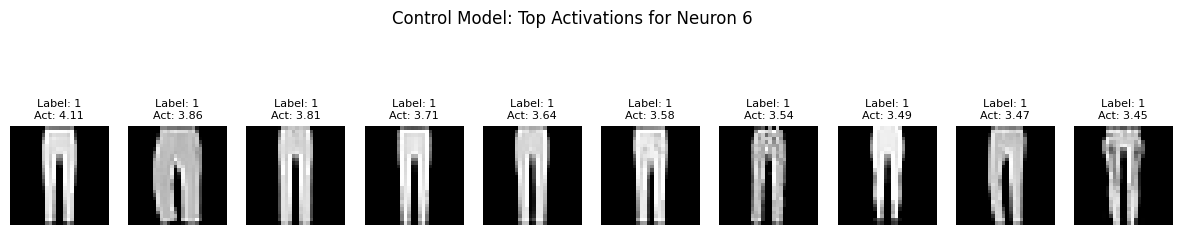

Scanning dataset for Neuron 18...


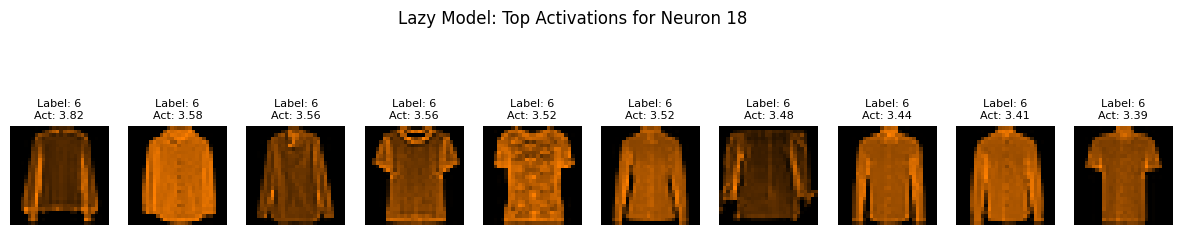

Scanning dataset for Neuron 18...


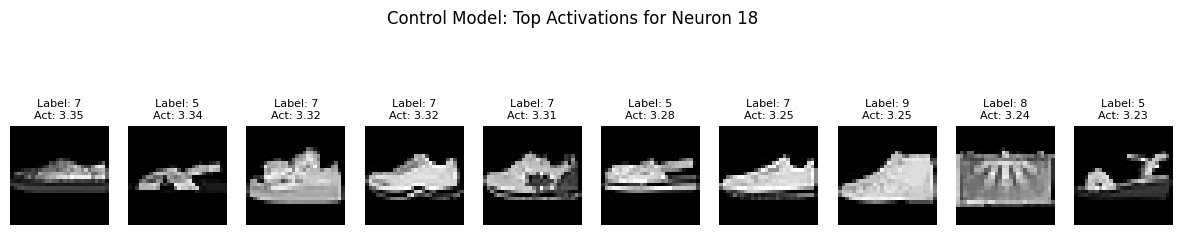

Scanning dataset for Neuron 27...


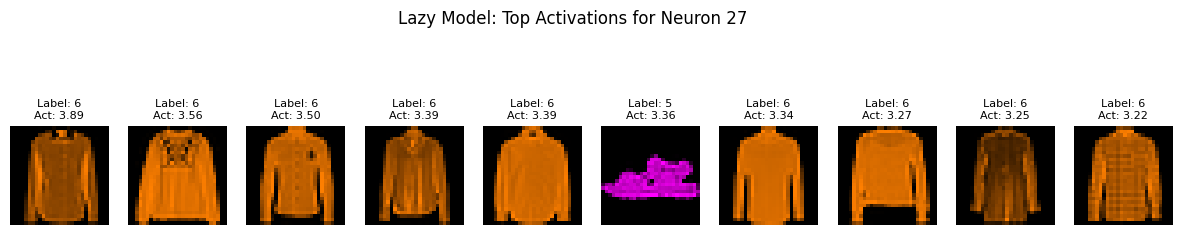

Scanning dataset for Neuron 27...


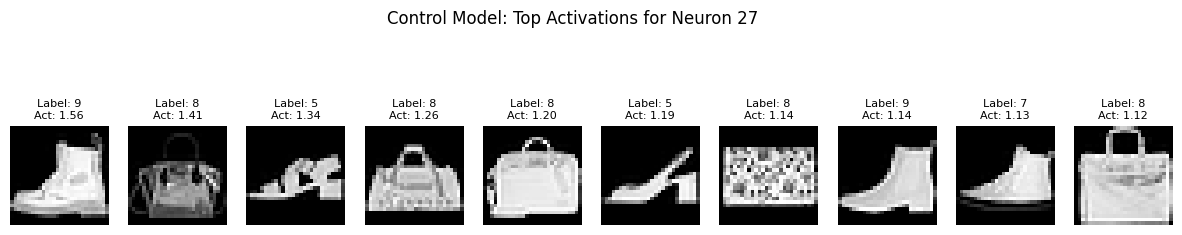

Scanning dataset for Neuron 55...


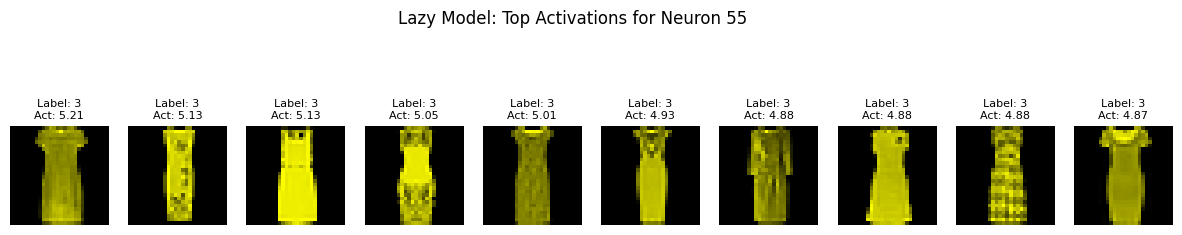

Scanning dataset for Neuron 55...


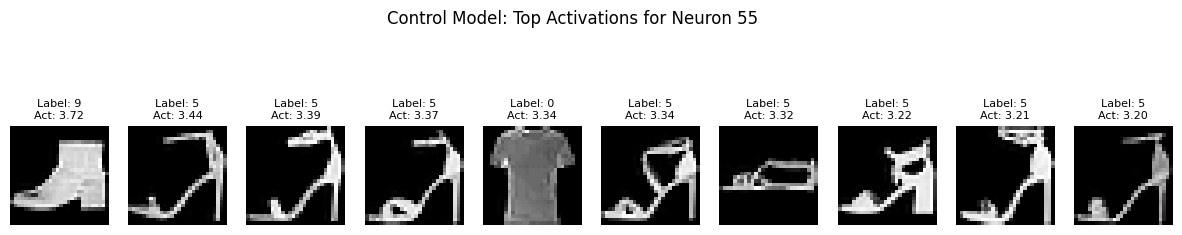

In [26]:
# checking for polysemanticity in neurons by investigating images with the top activations

def get_top_activations(model, layer, loader, neuron_id, top_k=10):
    model.eval()
    
    # store (activation_value, image, label)
    top_images = []
    
    hook = Hook(layer)
    
    print(f"Scanning dataset for Neuron {neuron_id}...")
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            model(images)
            
            layer_out = hook.output
            
            # measure how much this specific neuron fired (max value across the grid)
            activations = torch.amax(layer_out[:, neuron_id, :, :], dim=(1, 2))
            
            for i in range(len(images)):
                val = activations[i].item()
                # keep top k images
                top_images.append((val, images[i].cpu(), labels[i].item()))
                top_images.sort(key=lambda x: x[0], reverse=True)
                top_images = top_images[:top_k]
                
    hook.detach()
    return top_images

def plot_dataset_activations(top_images, neuron_id, model_name):
    fig, axes = plt.subplots(1, len(top_images), figsize=(15, 3))
    fig.suptitle(f"{model_name}: Top Activations for Neuron {neuron_id}", y=1.05)
    
    for i, (val, img, label) in enumerate(top_images):
        # convert tensor to image
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nAct: {val:.2f}", fontsize=8)
        axes[i].axis('off')
        
    plt.show()

# picking random neurons
# validation dataset (which is biased, like the training data)
for neu in [1, 6, 18, 27, 55]:
    target_neuron = neu
    
    # get top activations for the lazy model
    top_lazy = get_top_activations(model, model.layer4[1].conv2, validloader, target_neuron)
    plot_dataset_activations(top_lazy, target_neuron, "Lazy Model")
    
    # get top activations for the control model
    top_control = get_top_activations(control, control.layer4[1].conv2, c_validloader, target_neuron)
    plot_dataset_activations(top_control, target_neuron, "Control Model")

Scanning dataset for Neuron 1...


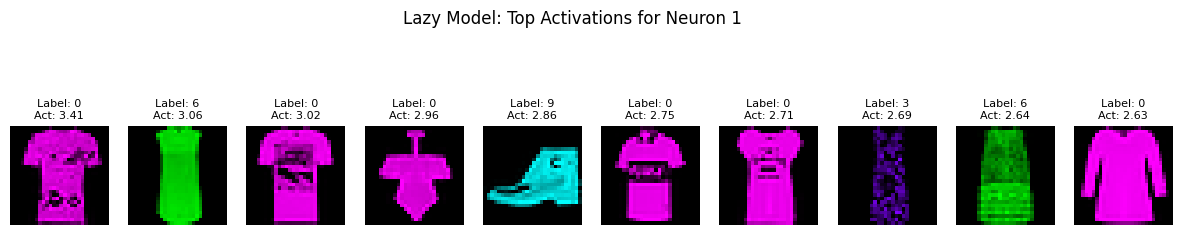

Scanning dataset for Neuron 1...


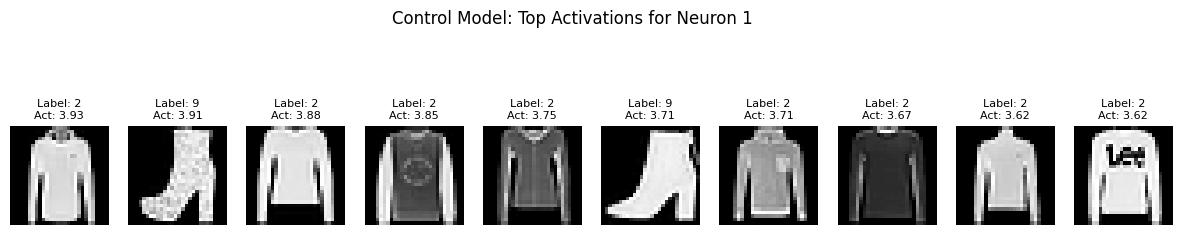

Scanning dataset for Neuron 6...


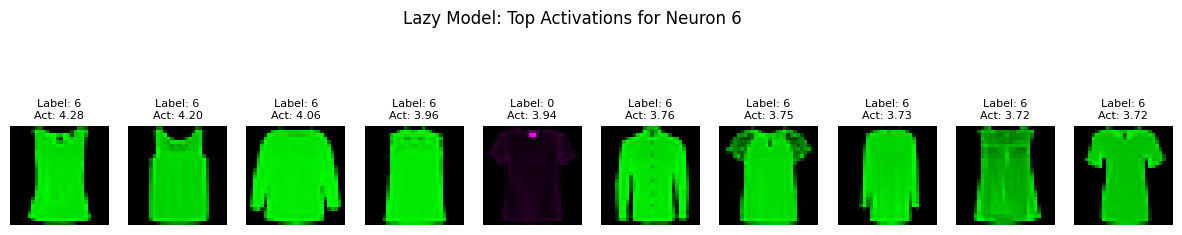

Scanning dataset for Neuron 6...


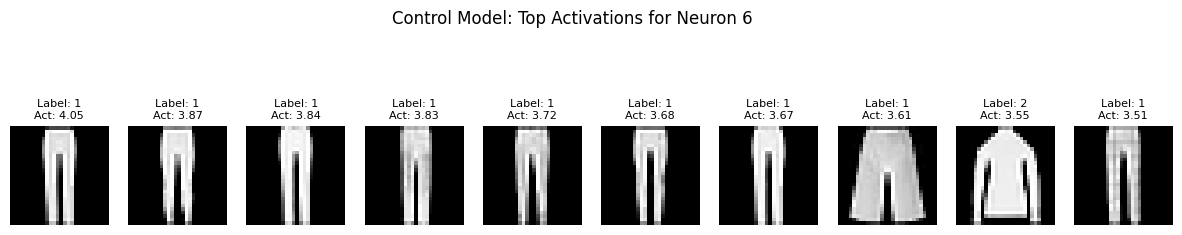

Scanning dataset for Neuron 18...


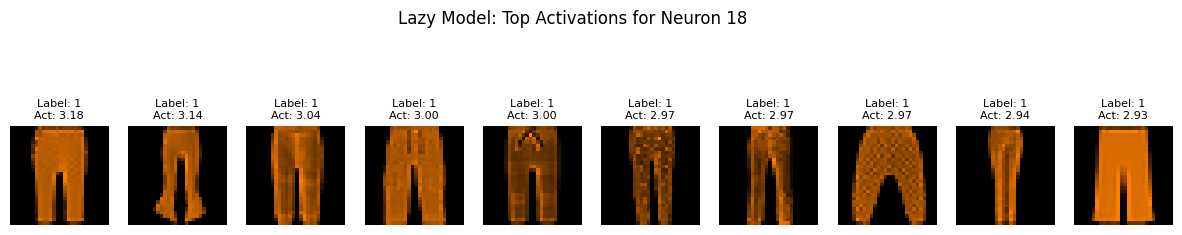

Scanning dataset for Neuron 18...


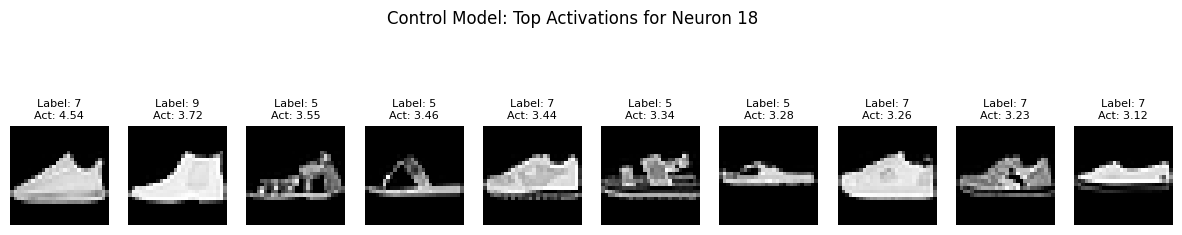

Scanning dataset for Neuron 27...


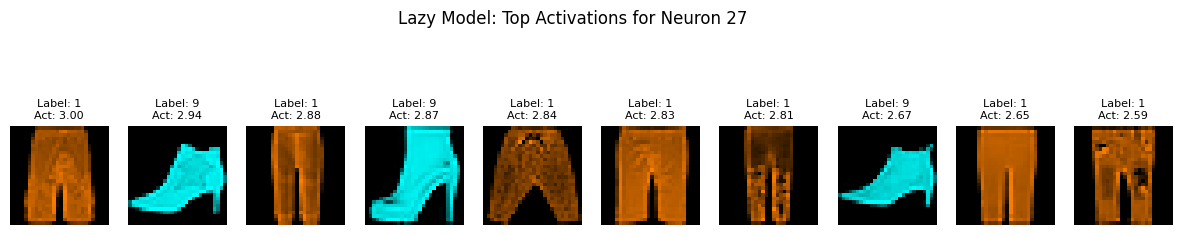

Scanning dataset for Neuron 27...


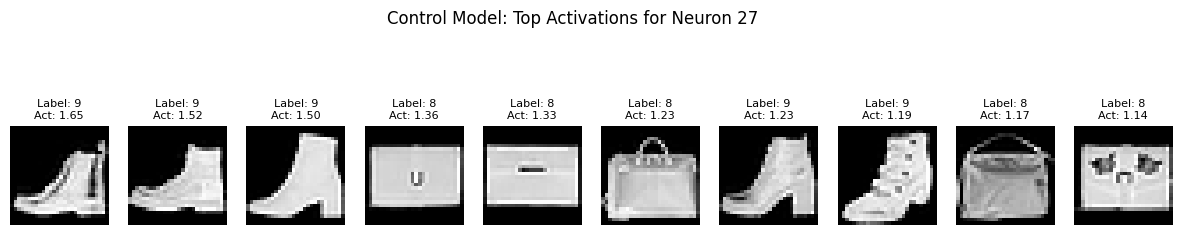

Scanning dataset for Neuron 55...


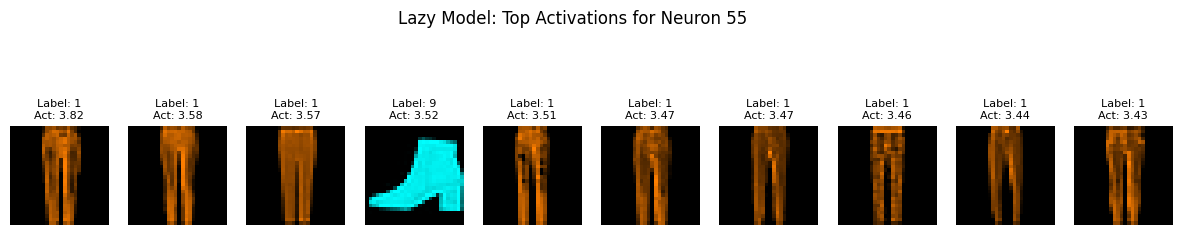

Scanning dataset for Neuron 55...


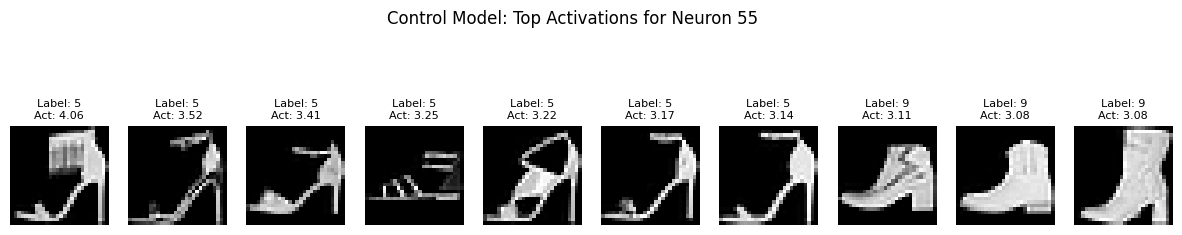

In [27]:
# picking random neurons
# test dataset (inverts the bias)
for neu in [1, 6, 18, 27, 55]:
    target_neuron = neu
    
    # get top activations for the lazy model
    top_lazy = get_top_activations(model, model.layer4[1].conv2, testloader, target_neuron)
    plot_dataset_activations(top_lazy, target_neuron, "Lazy Model")
    
    # get top activations for the control model
    top_control = get_top_activations(control, control.layer4[1].conv2, c_testloader, target_neuron)
    plot_dataset_activations(top_control, target_neuron, "Control Model")

In [9]:
class GradCAM:
    def __init__(self, model, targ_layer):
        self.model = model
        self.targ_layer = targ_layer
        self.gradients = None
        self.activations = None
        
        # forward hooks for activations (feature maps)
        # callback to save_activation to store the feature map captured by the forward hook
        targ_layer.register_forward_hook(self.save_activation)
        # backward hooks for gradients
        # callback to save_gradient to store gradients calculated
        targ_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # backward hook will receive a tuple of tensors
        # gradients computed in reverse, so grad_output[0] is the required tensor of gradients
        # for more complex models where layers have multiple outputs (e.g. RNNs which might output predictions and a hidden state)
        # the tuple has multiple tensors, where [0] has gradients of predictions, [1] has gradients of hidden states, and so on
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image, target_class_index=None):
        # forward pass
        self.model.eval()
        output = self.model(input_image)
        
        # if target class unspecified, use predicted class
        if target_class_index is None:
            target_class_index = torch.argmax(output).item()
            
        # zeroing gradients for backward pass
        self.model.zero_grad()
        
        # we calculate the gradients backward from the logit score of the target class
        # initialise a zero vector of length equal to the size of the last layer of the output
        # this will be the vector of gradient weights for backprop
        # set the target class value to 1 in the vector
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(device)
        one_hot_output[0][target_class_index] = 1
        
        # backprop
        output.backward(gradient=one_hot_output)

        # gradients are stored as a 4D tensor [batchsize, channels, height, width]
        # averaging across batch, height and width dimensions, we get a 1D tensor
        # vector of "global importance weights" for each channel
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # note that here we assume batch size is 1 since we'll usually be working on creating a heatmap for an individual image
        # so averaging across the batch is effectively a squeeze operation
        
        # activations also stored as a 4D tensor
        # since there is only one image in the batch, we access it to get a 3D tensor [channels, height, width]
        activations = self.activations.detach()[0]
        
        # iterate over all channels and multiply the global importance weights with the corresponding activations
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        # ReLU of linear combination of these products is then taken in the GradCAM approach proposed in the 2019 paper
        # here, we take the mean for normalisation purposes, since dividing by const no. of channels does not affect it
        heatmap = torch.mean(activations, dim=0).cpu()
        
        # we then apply the ReLU function to enforce only positive values (all negative values become zero)
        heatmap = nn.functional.relu(heatmap)
        
        # normalise to [0,1]
        if torch.max(heatmap) != 0:
             heatmap /= torch.max(heatmap)
        
        return heatmap.numpy(), target_class_index

In [10]:
# function to overlay heatmap generated by GradCAM over the original image
def overlay_heatmap(heatmap, original):
    heatmap = cv2.resize(heatmap, (28, 28))
    
    # scale heatmap tensor to [0,255]
    # then apply suitable colourmap
    heatmap = np.uint8(255 * heatmap)
    heatmap_coloured = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
    # scale original image tensor to [0,255] too
    orig = original.permute(1, 2, 0).cpu().numpy()
    orig = np.uint8(255 * (orig - orig.min()) / (orig.max() - orig.min()))
    # use cv2.cvtcolor to transform one colour space to another
    # in this case, RGB to BGR, which is standard for OpenCV
    orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
    
    superimposed = cv2.addWeighted(heatmap_coloured, 0.6, orig, 0.4, 0)
    
    # reconvert to RGB
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

In [11]:
# create a separate instance of the biased model
gc_lazymodel = create_model()
gc_lazymodel.load_state_dict(torch.load("./FashionMNIST/lazymodel.pth", map_location=device))
gc_lazymodel.to(device)

# init GradCAM on final layer
grad_cam_lazy = GradCAM(gc_lazymodel, gc_lazymodel.layer4)

# helper function to retrieve images of specific class
def get_sample(dataset, target_class, forced_color_idx=None):
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label == target_class:
            return img.unsqueeze(0).to(device), label

# heatmap analysis with GradCAM for a specified model
def gradcam_comparison(grad_cam, traindata, testdata, t_class=0):
    # retrieve an image of specific class (say, 0) from the biased dataset
    aligned_img, label_a = get_sample(traindata, target_class=t_class) 
    
    # retrieve an image of the same class from the conflicting (inverted) dataset
    conflict_img, label_c = get_sample(testdata, target_class=t_class)

    heatmap_a, pred_a = grad_cam.generate_heatmap(aligned_img)
    overlay_a = overlay_heatmap(heatmap_a, aligned_img[0])
    
    heatmap_c, pred_c = grad_cam.generate_heatmap(conflict_img)
    overlay_c = overlay_heatmap(heatmap_c, conflict_img[0])
    
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    # aligned image (matches with train data)
    img_np_a = aligned_img[0].permute(1, 2, 0).cpu().numpy()
    axes[0, 0].imshow(img_np_a)
    axes[0, 0].set_title(f"Aligned Input\n(Class {label_a})")
    axes[0, 1].imshow(heatmap_a, cmap='jet')
    axes[0, 1].set_title("Grad-CAM Heatmap")
    axes[0, 2].imshow(overlay_a)
    axes[0, 2].set_title(f"Prediction: {pred_a}")
    # conflict image (does not match train data)
    img_np_c = conflict_img[0].permute(1, 2, 0).cpu().numpy()
    axes[1, 0].imshow(img_np_c)
    axes[1, 0].set_title(f"Conflict Input\n(Class {label_c})")
    axes[1, 1].imshow(heatmap_c, cmap='jet')
    axes[1, 1].set_title("Grad-CAM Heatmap")
    axes[1, 2].imshow(overlay_c)
    axes[1, 2].set_title(f"Prediction: {pred_c}")
    
    plt.tight_layout()
    plt.show()

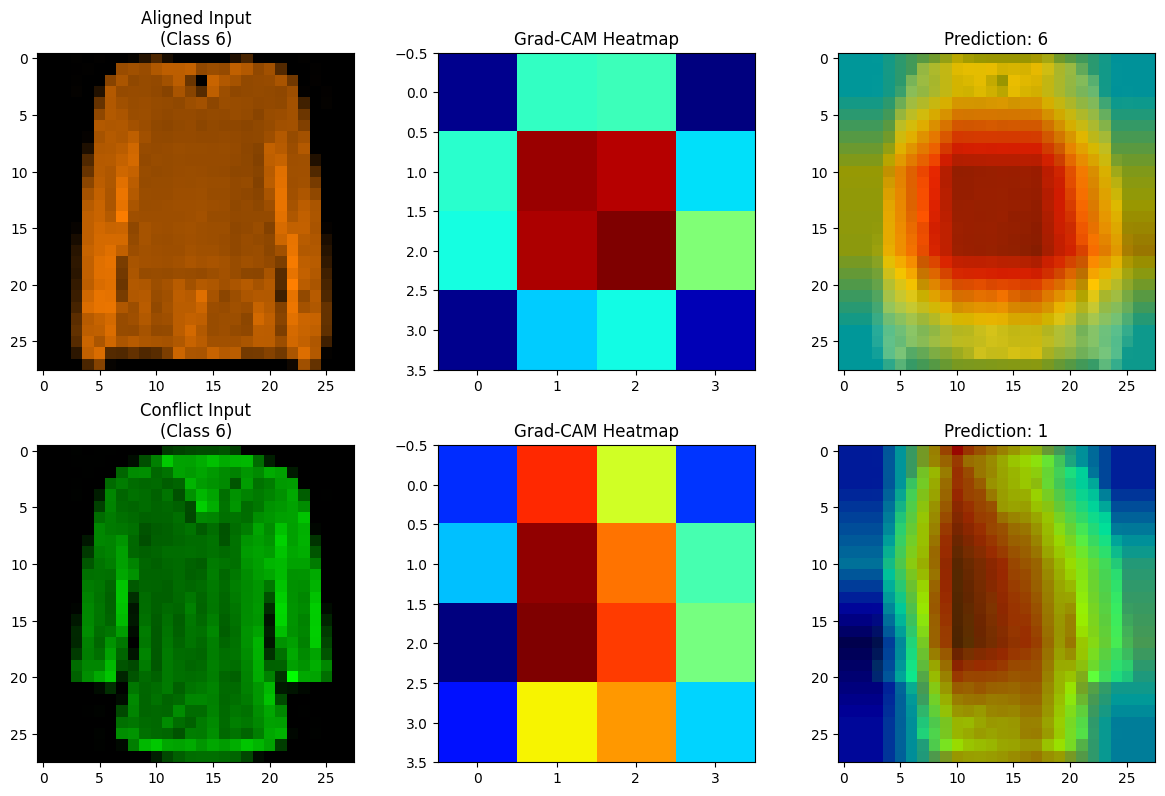

In [13]:
# GradCAM heatmap analysis for lazy model
gradcam_comparison(grad_cam_lazy, traindata, testdata, 6)

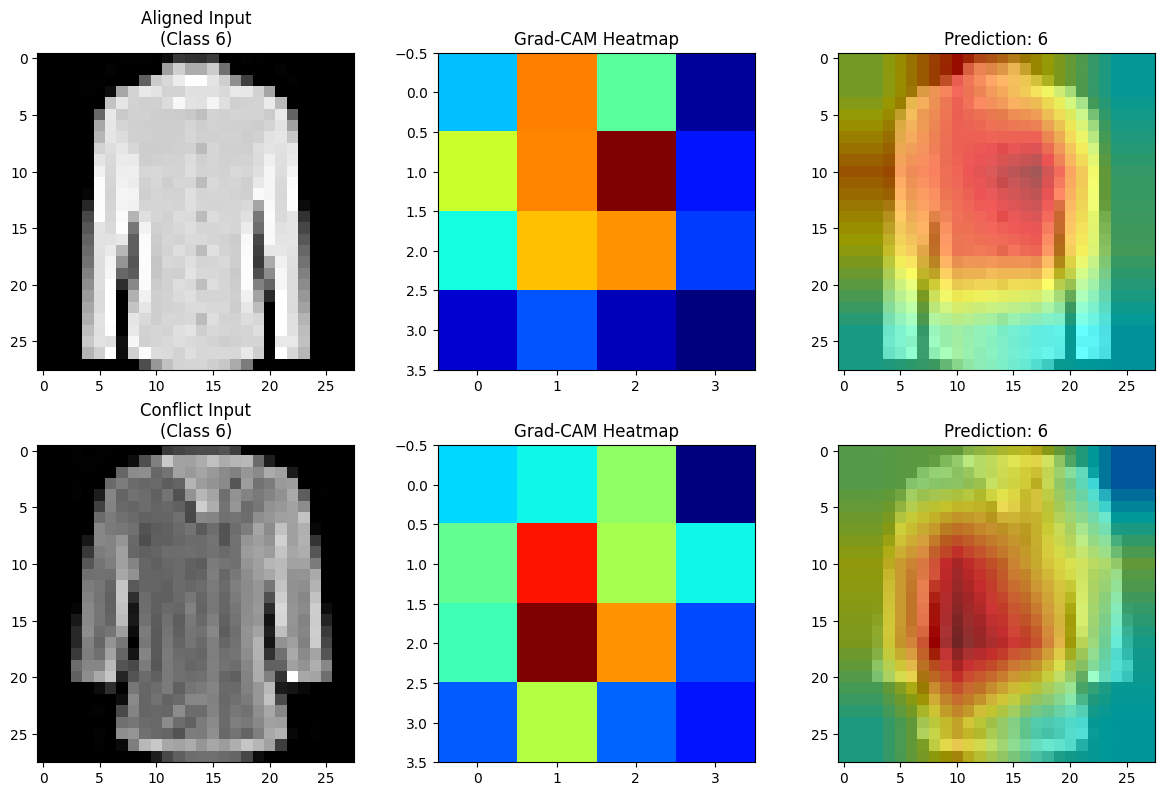

In [32]:
# create a separate instance of the control model
gc_controlmodel = create_model()
gc_controlmodel.load_state_dict(torch.load("./FashionMNIST/controlmodel.pth", map_location=device))
gc_controlmodel.to(device)

# init GradCAM on final layer
grad_cam_control = GradCAM(gc_controlmodel, gc_controlmodel.layer4)

# GradCAM heatmap analysis for control model
gradcam_comparison(grad_cam_control, c_train, c_test, 6)

In [33]:
# for training a robust model on the same dataset, we define this class to modularise the training process
# new training strategies can be easily appended to the class
class Trainer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.optimiser = optim.Adam(model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        
        # sobel-feldman kernels used for edge detection in images
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(device)

    # method 1: reweighting
    def train_step_reweighting(self, images, labels, gamma=2.0):
        """
        since there are 5% of images in the training dataset which are conflicting with the bias, reweight the model
        to give more importance to those images rather than the rest of the biased dataset
        """
        outputs = self.model(images)
        
        # calculates standard cross entropy loss for each image (not reduced into one average value)
        ce_loss = nn.functional.cross_entropy(outputs, labels, reduction='none')
        
        # calculate the probability of the correct class for each image
        # since for cross entropy loss, loss = -ln(p_correct) => p_correct = exp(-loss)
        pt = torch.exp(-ce_loss)
        
        # focal term
        # modify gamma as required based on dataset!
        focal_weight = (1 - pt) ** gamma
        
        # loss after reweighting
        loss = (focal_weight * ce_loss).mean()
        
        return loss, {"avg_weight": focal_weight.mean().item()}

    # method 2: gradient penalty
    def train_step_grad_penalty(self, images, labels, lambda_gp=1.0):
        """
        similar to R1 regularisation used in GANs
        apply a gradient penalty to punish the model if it is sensitive to small pixel changes
        (the gradients should be smooth)
        """
        images.requires_grad = True
        outputs = self.model(images)
        class_loss = self.criterion(outputs, labels)
        
        grad_params = torch.autograd.grad(class_loss, images, create_graph=True)[0]
        
        grad_norm = grad_params.view(grad_params.shape[0], -1).norm(2, dim=1)
        grad_penalty = (grad_norm ** 2).mean()
        
        return class_loss + (lambda_gp * grad_penalty), {"penalty": grad_penalty.item()}

    # method 3: saliency guidance (based on sobel edge detection)
    def train_step_saliency(self, images, labels, lambda_sal=50.0):
        """
        train the model to focus on edges/curves in the image rather than other features like colour
        edge set can be extracted from the image by applying Sobel-Feldman filters
        """
        images.requires_grad = True
        outputs = self.model(images)
        class_loss = self.criterion(outputs, labels)
        
        grad_params = torch.autograd.grad(class_loss, images, create_graph=True)[0]
        saliency = grad_params.abs().max(dim=1, keepdim=True)[0]
        
        # retrieve ground truth edges
        with torch.no_grad():
            gray = images.mean(dim=1, keepdim=True)
            gx = nn.functional.conv2d(gray, self.sobel_x, padding=1)
            gy = nn.functional.conv2d(gray, self.sobel_y, padding=1)
            edges = torch.sqrt(gx**2 + gy**2)
            edges = (edges - edges.min()) / (edges.max() - edges.min() + 1e-6)
            mask_non_edges = (edges < 0.2).float() 
            
        saliency_loss = (saliency * mask_non_edges).mean()
        
        return class_loss + (lambda_sal * saliency_loss), {"saliency": saliency_loss.item()}
    
    # helper function for augmenting images by selectively masking (occluding) a part of the image
    def apply_occlusion(self, images, hole_size=14):
        # create a deep copy of the tensor
        occluded = images.clone()
        h, w = images.shape[2], images.shape[3]
        
        # iterate over all images in the batch
        for i in range(images.shape[0]):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - hole_size // 2, 0, h)
            y2 = np.clip(y + hole_size // 2, 0, h)
            x1 = np.clip(x - hole_size // 2, 0, w)
            x2 = np.clip(x + hole_size // 2, 0, w)
            
            # colour the mask black
            occluded[i, :, y1:y2, x1:x2] = 0
            
        return occluded
    
    # method 4: selective masking (occlusion)
    def train_step_occlusion(self, images, labels):
        """
        selective masking of images to encourage the model to learn from distributed features
        """
        # apply mask to image set
        occ_images = self.apply_occlusion(images, hole_size=12) # 12x12 hole in 28x28 image
        
        outputs = self.model(occ_images)
        loss = self.criterion(outputs, labels)
        
        return loss, {}

    # training loop
    def train_epoch(self, loader, strategy="standard"):
        self.model.train()
        total_loss = 0
        loop = tqdm(loader, desc=f"Training ({strategy})")
        
        for images, labels in loop:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimiser.zero_grad()

            if strategy == "reweighting":
                loss, metrics = self.train_step_reweighting(images, labels)
            elif strategy == "grad_penalty":
                loss, metrics = self.train_step_grad_penalty(images, labels)
            elif strategy == "saliency":
                loss, metrics = self.train_step_saliency(images, labels)
            elif strategy == "occlusion":
                loss, metrics = self.train_step_occlusion(images, labels)
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                metrics = {}
            
            loss.backward()
            self.optimiser.step()
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item(), **metrics)
            
        return total_loss / len(loader)

In [34]:
r_epochs = 15

robust = create_model()
trainer = Trainer(robust)
for ep in range(r_epochs):
    trainer.train_epoch(trainloader, strategy="reweighting")

accu_vali = evaluate_model(robust, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(robust, testloader, "Accuracy on difficult set (conflict)")

torch.save(robust.state_dict(), "./FashionMNIST/robustmodelv1.pth")

Training (reweighting): 100%|█████████████████████████████████████████████| 160/160 [00:29<00:00,  5.49it/s, avg_weight=0.0146, loss=0.0118]


Accuracy on easy set (biased):  98.73%
Accuracy on difficult set (conflict):  89.74%


In [35]:
robust = create_model()
trainer = Trainer(robust)
for ep in range(r_epochs):
    trainer.train_epoch(trainloader, strategy="grad_penalty")

accu_vali = evaluate_model(robust, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(robust, testloader, "Accuracy on difficult set (conflict)")

torch.save(robust.state_dict(), "./FashionMNIST/robustmodelv2.pth")

Training (grad_penalty): 100%|██████████████████████████████████████████████| 160/160 [01:40<00:00,  1.59it/s, loss=0.0356, penalty=9.41e-5]


Accuracy on easy set (biased):  98.52%
Accuracy on difficult set (conflict):  85.63%


In [36]:
robust = create_model()
trainer = Trainer(robust)
for ep in range(r_epochs):
    trainer.train_epoch(trainloader, strategy="saliency")

accu_vali = evaluate_model(robust, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(robust, testloader, "Accuracy on difficult set (conflict)")

torch.save(robust.state_dict(), "./FashionMNIST/robustmodelv3.pth")

Training (saliency): 100%|██████████████████████████████████████████████████| 160/160 [01:40<00:00,  1.59it/s, loss=0.048, saliency=1.23e-5]


Accuracy on easy set (biased):  98.63%
Accuracy on difficult set (conflict):  88.63%


In [37]:
robust = create_model()
trainer = Trainer(robust)
for ep in range(r_epochs):
    trainer.train_epoch(trainloader, strategy="occlusion")

accu_vali = evaluate_model(robust, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(robust, testloader, "Accuracy on difficult set (conflict)")

torch.save(robust.state_dict(), "./FashionMNIST/robustmodelv4.pth")

Training (occlusion): 100%|██████████████████████████████████████████████████████████████████| 160/160 [00:30<00:00,  5.25it/s, loss=0.0637]


Accuracy on easy set (biased):  98.87%
Accuracy on difficult set (conflict):  85.06%


In [14]:
def targ_adv_attack(model, image, target_label, epsilon=0.05, alpha=0.01, num_steps=50):
    """
    targeted adversarial attack by modifying pixels in the image
    uses FAST GRADIENT SIGN METHOD
    aims to make the model predict a specific incorrect class
    for a successful attack, epsilon must be <= 0.05
    """
    modified = image.clone().detach().to(device)
    modified.requires_grad = True
    target_tensor = torch.tensor([target_label]).to(device)
    
    for step in range(num_steps):
        output = model(modified)

        # get the probabilities of each class (returned by softmax fn applied to the logit scores)
        probs = torch.nn.functional.softmax(output, dim=1)
        curr_conf = probs[0, target_label].item()
        
        # stop optimisation if model predicts target class with confidence > 90%
        if curr_conf > 0.90:
            return modified.detach(), curr_conf

        # calculate loss wrt target class
        loss = nn.functional.cross_entropy(output, target_tensor)
        # minimise loss by gradient descent
        model.zero_grad()
        loss.backward()
        
        data_grad = modified.grad.data
        # fast gradient sign method
        # updates all the pixels in the image in the direction (sign) that minimises loss wrt target class
        # alpha here is the learning rate; directions are values from {-1.0, 0.0, 1.0}
        modified.data = modified.data - (alpha * data_grad.sign())
        
        # measuring difference delta of modified image from the original
        # this difference must be in the range [-eps, +eps]
        delta = modified.data - image.data
        delta = torch.clamp(delta, -epsilon, epsilon)
        modified.data = image.data + delta
        
        # constraint to ensure image is valid (pixel values must be between 0 and 1)
        modified.data = torch.clamp(modified.data, 0, 1)
        # reset gradients to zero (in-place)
        modified.grad.zero_()
        
    pred = model(modified)
    conf = torch.nn.functional.softmax(pred, dim=1)[0, target_label].item()
    
    return modified.detach(), conf

In [15]:
robust_rw = create_model()
robust_gp = create_model()
robust_sal = create_model()
robust_occ = create_model()

robust_rw.load_state_dict(torch.load("./FashionMNIST/robustmodelv1.pth", map_location=device))
robust_gp.load_state_dict(torch.load("./FashionMNIST/robustmodelv2.pth", map_location=device))
robust_sal.load_state_dict(torch.load("./FashionMNIST/robustmodelv3.pth", map_location=device))
robust_occ.load_state_dict(torch.load("./FashionMNIST/robustmodelv4.pth", map_location=device))

<All keys matched successfully>

In [16]:
def find_minimum_epsilon(model, image, target_label, max_epsilon=0.2, num_steps=50):
    model.eval()
    
    # start with eps at 0.005, and iteratively increase eps by 0.005 until attack is successful
    # we keep an upper bound on the epsilon values tried, max_epsilon
    for eps_tensor in torch.arange(0.005, max_epsilon, 0.005):
        # extract float from tensor
        eps = eps_tensor.item()
        # run targeted adversarial attack
        adv_img, conf = targ_adv_attack(model, image, target_label, epsilon=eps, num_steps=num_steps)
        
        if conf > 0.90:
            return eps, conf, adv_img

    print(f"Adversarial attack unsuccessful within epsilon<={max_epsilon} bound.")
    return max_epsilon, 0.0, image

In [17]:
model_names = ["Biased", "Reweight", "GradPenalty", "Saliency", "Occlusion"]
models = [gc_lazymodel, robust_rw, robust_gp, robust_sal, robust_occ]

def run_attack(models, model_names, in_class, out_class):
    orig_img, orig_label = get_sample(testdata, target_class=in_class) 
    targ_class = out_class
    
    print(f"EXPERIMENT: Targeted attack - predict class {orig_label} as class {targ_class}")
    
    results = []
    
    for name, model in zip(model_names, models):
        print(f"Running attack on {name} model...", end="\t\t")
        # find minimum epsilon that successfully results in the desired misclassification (below a specified threshold)
        eps, conf, adv_img = find_minimum_epsilon(model, orig_img, targ_class)
        
        # calculating noise tensor
        noise_tensor = (adv_img - orig_img)
        
        results.append({
            "name": name,
            "epsilon": eps,
            "image": adv_img,
            "noise": noise_tensor
        })
        
        print(f"Cracked at Eps: {eps:.4f}")
    
    # visualise the outputs of the attack attempts
    # in a 10x2 grid
    
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    fig.suptitle(f"Targeted Adversarial Attack\n({orig_label} $\\rightarrow$ {targ_class})", fontsize=16, y=1.02)

    # original image (for reference)
    ax_orig = axes[0, 0]
    orig_disp = orig_img[0].permute(1, 2, 0).cpu()
    ax_orig.imshow(orig_disp)
    ax_orig.set_title("Original Image", fontsize=12, fontweight='bold')
    ax_orig.axis('off')

    # attacking lazy model
    lazy_res = results[0]
    lazy_disp = lazy_res["image"][0].permute(1, 2, 0).cpu()
    
    ax_lazy = axes[0, 1]
    ax_lazy.imshow(lazy_disp)
    # colour the text accordingly to show if attack was successful (below eps=0.05)
    color = 'red' if lazy_res['epsilon'] < 0.05 else 'green'
    ax_lazy.set_title(f"Lazy Model Attack\nEps: {lazy_res['epsilon']:.3f}", color=color, fontweight='bold')
    ax_lazy.axis('off')
    
    
    # attacking four versions of the robust model
    for i in range(1, 5): 
        row_idx = i
        res = results[i]
        
        # adversarial image on LHS
        ax_img = axes[row_idx, 0]
        adv_disp = res["image"][0].permute(1, 2, 0).cpu()
        
        color = 'green' if res['epsilon'] > 0.05 else 'red'
        ax_img.imshow(adv_disp)
        ax_img.set_title(f"{res['name']} Result\nEps: {res['epsilon']:.3f}", color=color, fontweight='bold')
        ax_img.axis('off')
        
        # noise pattern added to fool the model on RHS
        ax_noise = axes[row_idx, 1]
        noise_map = res["noise"].abs().sum(dim=1)[0].cpu()
        
        # use colourmaps for better contrast when visualising noise
        im = ax_noise.imshow(noise_map, cmap='magma')
        ax_noise.set_title(f"{res['name']} Noise\n", fontweight='bold')
        ax_noise.axis('off')
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.97)
    plt.show()

EXPERIMENT: Targeted attack - predict class 2 as class 5
Running attack on Biased model...		Cracked at Eps: 0.0700
Running attack on Reweight model...		Cracked at Eps: 0.0500
Running attack on GradPenalty model...		Cracked at Eps: 0.0450
Running attack on Saliency model...		Cracked at Eps: 0.0650
Running attack on Occlusion model...		Cracked at Eps: 0.0400


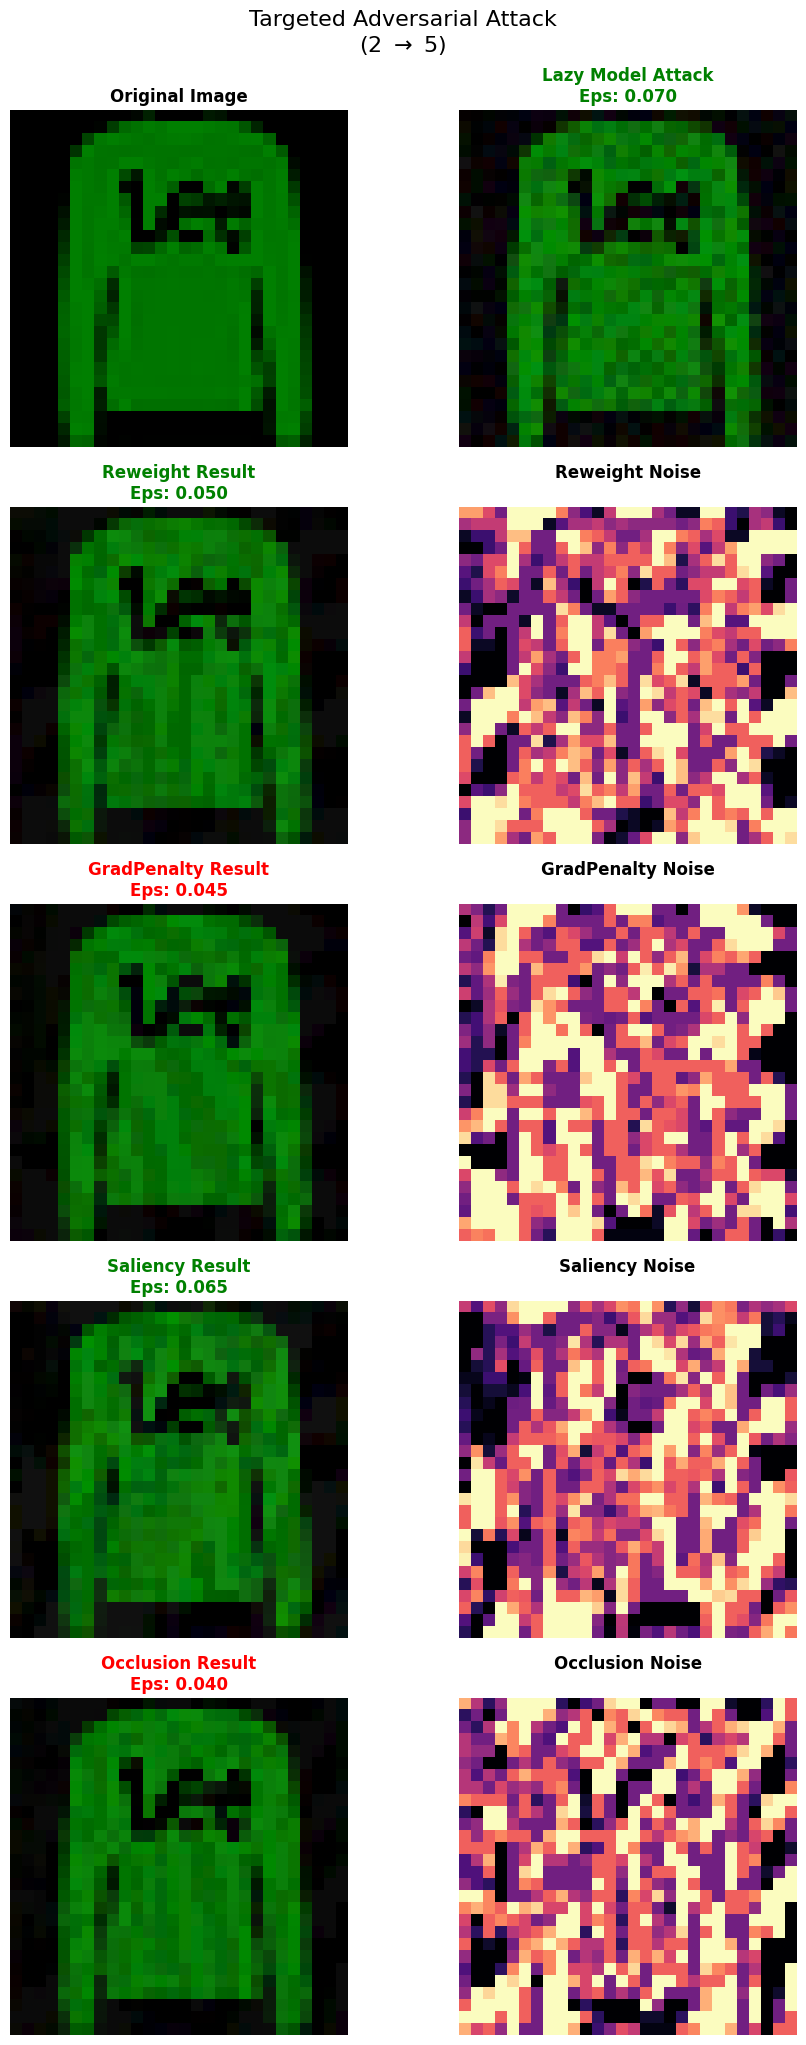

In [19]:
run_attack(models, model_names, 2, 5)